In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install deap

In [3]:
!pip install bitstring

In [4]:
!pip install transforms3d

In [5]:
!pip install tsaug

In [6]:
import os
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from scipy import stats 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import mean_squared_error
from tensorflow.keras.utils import plot_model
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score
from sklearn.metrics import max_error
from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
from bitstring import BitArray
from scipy.interpolate import CubicSpline      # for warping
from transforms3d.axangles import axangle2mat  # for rotation
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse

from math import sqrt
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder

In [7]:
pwd

'/content'

In [8]:
%cd "/content/drive/My Drive/Colab Notebooks/covid-dataset/"

/content/drive/My Drive/Colab Notebooks/covid-dataset


In [9]:
#%%time 
#!wget -O owid-covid-data.csv https://covid.ourworldindata.org/data/owid-covid-data.csv

In [10]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/covid-dataset/owid-covid-data.csv') # having First.csv zipped file.

In [11]:
#%%time 
#!wget -O owid-covid-data.csv https://covid.ourworldindata.org/data/owid-covid-data.csv

In [12]:
# Les 5 premères lignes du dataset 
df.head(5)

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,tests_per_case,positive_rate,tests_units,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
3,AFG,Asia,Afghanistan,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
4,AFG,Asia,Afghanistan,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [13]:
df[df.continent  == 'Africa'].shape
# soit 54 pays en afrique ,3 mois de COVID = approximativement 4800

(8414, 36)

In [14]:
#Taille des données de COVID pour le Maroc
df[df.location  == 'Morocco'].shape

(191, 36)

In [15]:
#Première date d'enregistrement de cas dans le monde 
df.date.min()

'2019-12-31'

In [16]:
# dernière date d'enregistrement pour notre datset
df.date.max()

'2020-08-15'

In [17]:
# Première date d'enregistrement de cas au Maroc 
df[(df.location  == 'Morocco')].date.min()

'2020-02-07'

In [18]:
# dernière date d'enregistrement de cas au Maroc 
df[(df.location  == 'Morocco')].date.max()

'2020-08-15'

In [19]:
df.date= pd.to_datetime(df['date'],format='%Y-%m-%d')

In [20]:
df=df[['new_cases','total_cases','total_deaths','new_deaths', 'population','date','location']]


In [21]:
df = df.fillna(df.median())

In [22]:
df[(df.location  == 'Morocco')].tail(10)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23085,1283.0,28500.0,435.0,18.0,36910558.0,2020-08-06,Morocco
23086,1144.0,29644.0,449.0,14.0,36910558.0,2020-08-07,Morocco
23087,1018.0,30662.0,461.0,12.0,36910558.0,2020-08-08,Morocco
23088,1345.0,32007.0,480.0,19.0,36910558.0,2020-08-09,Morocco
23089,1230.0,33237.0,498.0,18.0,36910558.0,2020-08-10,Morocco
23090,826.0,34063.0,516.0,18.0,36910558.0,2020-08-11,Morocco
23091,1132.0,35195.0,533.0,17.0,36910558.0,2020-08-12,Morocco
23092,1499.0,36694.0,556.0,23.0,36910558.0,2020-08-13,Morocco
23093,1241.0,37935.0,584.0,28.0,36910558.0,2020-08-14,Morocco
23094,1306.0,39241.0,611.0,27.0,36910558.0,2020-08-15,Morocco


In [23]:
def DA_Jitter(X, sigma=0.05):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    myNoise =  np.add(myNoise,abs(np.min(myNoise)))
    return X+myNoise

In [24]:
def DA_Scaling(X, sigma=0.1):
    scalingFactor = np.random.normal(loc=1.0, scale=sigma, size=(1,X.shape[1])) # shape=(1,3)
    scalingFactor = np.add(scalingFactor,abs(np.min(scalingFactor)))
    myNoise = np.matmul(np.ones((X.shape[0],1)), scalingFactor)
    return X*myNoise

In [25]:
def DA_Rotation(X):
    axis = np.random.uniform(low=-1, high=1, size=X.shape[1])
    angle = np.random.uniform(low=-np.pi, high=np.pi)
    return np.matmul(X , axangle2mat(axis,angle))

In [26]:
#df['month'] = df['date'].dt.month

In [27]:
nb_seq=2
n_out=7
nb_col=5

In [28]:
start_date = '2020-03-02'
end_date = '2020-05-24'
start_date2 = '2020-05-25'
end_date2 = '2020-06-14'

In [29]:
#mask = (covid_data['date'] >= start_date) & (covid_data['date'] <= end_date) &  (covid_data['location'].isin(['Morocco']))
mask1 = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))

In [30]:
mask2 = (df['date'] >= start_date2) & (df['date'] <= end_date2) &  (df['location'].isin(['Morocco']))

In [31]:
df.sort_values(by=['location'], inplace=True)


In [32]:
X_train = df.loc[mask1].sort_index(axis = 0) 
X_train.shape

(84, 7)

In [33]:
X_train.head(5)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
22928,7.0,615.0,10.0,0.0,36910558.0,2020-03-02,Morocco
22929,1.0,1.0,0.0,0.0,36910558.0,2020-03-03,Morocco
22930,7.0,615.0,10.0,0.0,36910558.0,2020-03-04,Morocco
22931,7.0,615.0,10.0,0.0,36910558.0,2020-03-05,Morocco
22932,1.0,2.0,0.0,0.0,36910558.0,2020-03-06,Morocco


In [34]:
X_train.tail(5)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23007,71.0,7023.0,193.0,1.0,36910558.0,2020-05-20,Morocco
23008,110.0,7133.0,194.0,1.0,36910558.0,2020-05-21,Morocco
23009,78.0,7211.0,196.0,2.0,36910558.0,2020-05-22,Morocco
23010,121.0,7332.0,197.0,1.0,36910558.0,2020-05-23,Morocco
23011,74.0,7406.0,198.0,1.0,36910558.0,2020-05-24,Morocco


In [35]:
#Date to add test set 
data_add_test = X_train[X_train.location =='Morocco'].tail(nb_seq)

In [36]:
'''
# AUGMENTATION 

start_date = '2020-06-25'
end_date = '2020-07-31'
mask = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))
X_1 = df.loc[mask].sort_index(axis = 0) 
X_2 = X_3 = X_4 =X_5=X_6=X_7=X_8= X_1

X_2[['new_cases']] = DA_Jitter(X_2[['new_cases']], sigma=1000)
X_2[['total_cases']] = X_2['total_cases'] + X_2['new_cases']
X_2[['new_deaths']] = DA_Jitter(X_2[['new_deaths']], sigma=10)
X_2[['total_deaths']] = X_2['total_deaths'] + X_2['new_deaths']

X_3[['new_cases']] = DA_Jitter(X_3[['new_cases']], sigma=500)
X_3[['total_cases']] = X_3['total_cases'] + X_3['new_cases']
X_3[['new_deaths']] = DA_Jitter(X_3['new_deaths'], sigma=20)
X_3[['total_deaths']] = X_3['total_deaths'] + X_3['new_deaths']

X_4[['new_cases']] = DA_Jitter(X_4[['new_cases']], sigma=1000)
X_4[['total_cases']] = X_4['total_cases'] + X_4['new_cases']
X_4[['new_deaths']] = DA_Jitter(X_4[['new_deaths']], sigma=30)
X_4[['total_deaths']] = X_4['total_deaths'] + X_4['new_deaths']

X_5[['new_cases']] = DA_Jitter(X_5[['new_cases']], sigma=1000)
X_5[['total_cases']] = X_5['total_cases'] + X_5['new_cases']
X_5[['new_deaths']] = DA_Jitter(X_5[['new_deaths']], sigma=40)
X_5[['total_deaths']] = X_5['total_deaths'] + X_5['new_deaths']

X_6[['new_cases']] = DA_Jitter(X_6[['new_cases']], sigma=1000)
X_6[['total_cases']] = X_6['total_cases'] + X_6['new_cases']
X_6[['new_deaths']] = DA_Jitter(X_6[['new_deaths']], sigma=50)
X_6[['total_deaths']] = X_6['total_deaths'] + X_6['new_deaths']


#X_7[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']] = DA_Scaling(X_6[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']], sigma=2000)
#X_8[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']] = DA_Scaling(X_7[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']], sigma=3000)
#X_4 = pd.DataFrame(X_4,columns=cols_need)
#print(X_1.shape)
X_train = pd.concat([X_train, X_2,X_3,X_4,X_5,X_6], ignore_index=True)
'''

"\n# AUGMENTATION \n\nstart_date = '2020-06-25'\nend_date = '2020-07-31'\nmask = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))\nX_1 = df.loc[mask].sort_index(axis = 0) \nX_2 = X_3 = X_4 =X_5=X_6=X_7=X_8= X_1\n\nX_2[['new_cases']] = DA_Jitter(X_2[['new_cases']], sigma=1000)\nX_2[['total_cases']] = X_2['total_cases'] + X_2['new_cases']\nX_2[['new_deaths']] = DA_Jitter(X_2[['new_deaths']], sigma=10)\nX_2[['total_deaths']] = X_2['total_deaths'] + X_2['new_deaths']\n\nX_3[['new_cases']] = DA_Jitter(X_3[['new_cases']], sigma=500)\nX_3[['total_cases']] = X_3['total_cases'] + X_3['new_cases']\nX_3[['new_deaths']] = DA_Jitter(X_3['new_deaths'], sigma=20)\nX_3[['total_deaths']] = X_3['total_deaths'] + X_3['new_deaths']\n\nX_4[['new_cases']] = DA_Jitter(X_4[['new_cases']], sigma=1000)\nX_4[['total_cases']] = X_4['total_cases'] + X_4['new_cases']\nX_4[['new_deaths']] = DA_Jitter(X_4[['new_deaths']], sigma=30)\nX_4[['total_deaths']] = X_4['total_deaths'

In [37]:
X_train.shape

(84, 7)

In [38]:
X_train.head(10)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
22928,7.0,615.0,10.0,0.0,36910558.0,2020-03-02,Morocco
22929,1.0,1.0,0.0,0.0,36910558.0,2020-03-03,Morocco
22930,7.0,615.0,10.0,0.0,36910558.0,2020-03-04,Morocco
22931,7.0,615.0,10.0,0.0,36910558.0,2020-03-05,Morocco
22932,1.0,2.0,0.0,0.0,36910558.0,2020-03-06,Morocco
22933,7.0,615.0,10.0,0.0,36910558.0,2020-03-07,Morocco
22934,7.0,615.0,10.0,0.0,36910558.0,2020-03-08,Morocco
22935,7.0,615.0,10.0,0.0,36910558.0,2020-03-09,Morocco
22936,7.0,615.0,10.0,0.0,36910558.0,2020-03-10,Morocco
22937,7.0,615.0,10.0,0.0,36910558.0,2020-03-11,Morocco


In [39]:
X_train.tail(10)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23002,95.0,6607.0,190.0,2.0,36910558.0,2020-05-15,Morocco
23003,45.0,6652.0,190.0,0.0,36910558.0,2020-05-16,Morocco
23004,89.0,6741.0,192.0,2.0,36910558.0,2020-05-17,Morocco
23005,129.0,6870.0,192.0,0.0,36910558.0,2020-05-18,Morocco
23006,82.0,6952.0,192.0,0.0,36910558.0,2020-05-19,Morocco
23007,71.0,7023.0,193.0,1.0,36910558.0,2020-05-20,Morocco
23008,110.0,7133.0,194.0,1.0,36910558.0,2020-05-21,Morocco
23009,78.0,7211.0,196.0,2.0,36910558.0,2020-05-22,Morocco
23010,121.0,7332.0,197.0,1.0,36910558.0,2020-05-23,Morocco
23011,74.0,7406.0,198.0,1.0,36910558.0,2020-05-24,Morocco


In [40]:
X_test = df.loc[mask2].sort_index(axis = 0) 

X_test.shape

(21, 7)

In [41]:
X_test = pd.concat([pd.DataFrame(data_add_test),X_test], ignore_index=True)
X_test = X_test.sort_index(axis = 0)

In [42]:
X_test

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
0,121.0,7332.0,197.0,1.0,36910558.0,2020-05-23,Morocco
1,74.0,7406.0,198.0,1.0,36910558.0,2020-05-24,Morocco
2,27.0,7433.0,199.0,1.0,36910558.0,2020-05-25,Morocco
3,99.0,7532.0,200.0,1.0,36910558.0,2020-05-26,Morocco
4,45.0,7577.0,202.0,2.0,36910558.0,2020-05-27,Morocco
5,24.0,7601.0,202.0,0.0,36910558.0,2020-05-28,Morocco
6,42.0,7643.0,202.0,0.0,36910558.0,2020-05-29,Morocco
7,71.0,7714.0,202.0,0.0,36910558.0,2020-05-30,Morocco
8,66.0,7780.0,204.0,2.0,36910558.0,2020-05-31,Morocco
9,27.0,7807.0,205.0,1.0,36910558.0,2020-06-01,Morocco


In [43]:
X_test['timestamp'] = pd.to_datetime(X_test['date'], infer_datetime_format=True)
X_test.set_index('timestamp', inplace=True)

X_train['timestamp'] = pd.to_datetime(X_train['date'], infer_datetime_format=True)
X_train.set_index('timestamp', inplace=True)

In [44]:
X_train=X_train[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']]

X_test=X_test[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']]
Y_test=X_test[['new_cases']]

Y_train=X_train[['new_cases']]

In [45]:
days=X_test[nb_seq:].index
days=days.sort_values()

In [46]:
#days=days[nb_seq:]

In [47]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(84, 5)
(84, 1)
(23, 5)
(23, 1)


In [48]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler2= MinMaxScaler(feature_range=(0, 1))

In [49]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [50]:

X_train=X_train
X_test=X_test
Y_train=Y_train
Y_test=Y_test

# ensure all data is float
X_train = X_train.astype('float32')
# ensure all data is float
X_test = X_test.astype('float32')
# ensure all data is float
Y_test = Y_test.astype('float32')
# ensure all data is float
Y_train = Y_train.astype('float32')

# normalize features

X_train= scaler.fit_transform(X_train)
X_test= scaler.fit_transform(X_test)
Y_train= scaler2.fit_transform(Y_train)
Y_test= scaler2.fit_transform(Y_test)

# reframe as supervised learning
# on doit toujours vers une conversion vers n_out ensuite con choisit le nombre de colonnes dont nous avons besoins
X_train = series_to_supervised(X_train, nb_seq, n_out)
X_test = series_to_supervised(X_test, nb_seq, n_out)
print(X_train)
print(X_train.shape)
print(X_test.shape)
Y_train = series_to_supervised(Y_train, nb_seq, n_out)
Y_test = series_to_supervised(Y_test, nb_seq, n_out)
print(Y_train.shape)
print(Y_test.shape)


    var1(t-2)  var2(t-2)  var3(t-2)  ...  var3(t+6)  var4(t+6)  var5(t+6)
2    0.024911   0.082917   0.050505  ...   0.050505   0.000000        0.0
3    0.003559   0.000000   0.000000  ...   0.050505   0.000000        0.0
4    0.024911   0.082917   0.050505  ...   0.005051   0.066667        0.0
5    0.024911   0.082917   0.050505  ...   0.005051   0.000000        0.0
6    0.003559   0.000135   0.000000  ...   0.005051   0.000000        0.0
..        ...        ...        ...  ...        ...        ...        ...
73   0.775801   0.848076   0.949495  ...   0.974747   0.066667        0.0
74   0.487544   0.866577   0.949495  ...   0.979798   0.066667        0.0
75   0.334520   0.879271   0.949495  ...   0.989899   0.133333        0.0
76   0.338078   0.892100   0.959596  ...   0.994950   0.066667        0.0
77   0.160142   0.898177   0.959596  ...   1.000000   0.066667        0.0

[76 rows x 45 columns]
(76, 45)
(15, 45)
(76, 9)
(15, 9)


In [51]:
print(X_test)

    var1(t-2)  var2(t-2)  var3(t-2)  ...  var3(t+6)  var4(t+6)  var5(t+6)
2    0.880342   0.000000   0.000000  ...   0.466666        1.0        0.0
3    0.478633   0.054411   0.066667  ...   0.533333        0.5        0.0
4    0.076923   0.074265   0.133333  ...   0.533333        0.0        0.0
5    0.692308   0.147058   0.200000  ...   0.599999        0.5        0.0
6    0.230769   0.180147   0.333333  ...   0.599999        0.0        0.0
7    0.051282   0.197794   0.333333  ...   0.733334        1.0        0.0
8    0.205128   0.228676   0.333333  ...   0.733334        0.0        0.0
9    0.452991   0.280882   0.333333  ...   0.733334        0.0        0.0
10   0.410256   0.329412   0.466666  ...   0.733334        0.0        0.0
11   0.076923   0.349265   0.533333  ...   0.733334        0.0        0.0
12   0.068376   0.368382   0.533333  ...   0.866667        1.0        0.0
13   0.128205   0.392647   0.599999  ...   0.866667        0.0        0.0
14   0.324786   0.433824   0.599999  .

In [52]:
#col_y_need_train = df.filter(regex=("d.*"))

In [53]:
#col_y_need_train=X_train.columns[[35,40,45,50,55,60,65]]
#col_y_need_test=X_test.columns[[35,40,45,50,55,60,65]]
X_train

,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var1(t+1),var2(t+1),var3(t+1),var4(t+1),var5(t+1),var1(t+2),var2(t+2),var3(t+2),var4(t+2),var5(t+2),var1(t+3),var2(t+3),var3(t+3),var4(t+3),var5(t+3),var1(t+4),var2(t+4),var3(t+4),var4(t+4),var5(t+4),var1(t+5),var2(t+5),var3(t+5),var4(t+5),var5(t+5),var1(t+6),var2(t+6),var3(t+6),var4(t+6),var5(t+6)
2,0.024911,0.082917,0.050505,0.000000,0.0,0.003559,0.000000,0.000000,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.003559,0.000135,0.000000,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0
3,0.003559,0.000000,0.000000,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.003559,0.000135,0.000000,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0
4,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.003559,0.000135,0.000000,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.010676,0.000540,0.005051,0.066667,0.0
5,0.024911,0.082917,0.050505,0.000000,0.0,0.003559,0.000135,0.000000,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.010676,0.000540,0.005051,0.066667,0.0,0.003559,0.000675,0.005051,0.000000,0.0
6,0.003559,0.000135,0.000000,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.010676,0.000540,0.005051,0.066667,0.0,0.003559,0.000675,0.005051,0.000000,0.0,0.003559,0.000810,0.005051,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,0.775801,0.848076,0.949495,0.000000,0.0,0.487544,0.866577,0.949495,0.000000,0.0,0.334520,0.879271,0.949495,0.000000,0.0,0.338078,0.892100,0.959596,0.133333,0.0,0.160142,0.898177,0.959596,0.000000,0.0,0.316726,0.910196,0.969697,0.133333,0.0,0.459075,0.927616,0.969697,0.000000,0.0,0.291815,0.938690,0.969697,0.000000,0.0,0.252669,0.948278,0.974747,0.066667,0.0
74,0.487544,0.866577,0.949495,0.000000,0.0,0.334520,0.879271,0.949495,0.000000,0.0,0.338078,0.892100,0.959596,0.133333,0.0,0.160142,0.898177,0.959596,0.000000,0.0,0.316726,0.910196,0.969697,0.133333,0.0,0.459075,0.927616,0.969697,0.000000,0.0,0.291815,0.938690,0.969697,0.000000,0.0,0.252669,0.948278,0.974747,0.066667,0.0,0.391459,0.963133,0.979798,0.066667,0.0
75,0.334520,0.879271,0.949495,0.000000,0.0,0.338078,0.892100,0.959596,0.133333,0.0,0.160142,0.898177,0.959596,0.000000,0.0,0.316726,0.910196,0.969697,0.133333,0.0,0.459075,0.927616,0.969697,0.000000,0.0,0.291815,0.938690,0.969697,0.000000,0.0,0.252669,0.948278,0.974747,0.066667,0.0,0.391459,0.963133,0.979798,0.066667,0.0,0.277580,0.973666,0.989899,0.133333,0.0
76,0.338078,0.892100,0.959596,0.133333,0.0,0.160142,0.898177,0.959596,0.000000,0.0,0.316726,0.910196,0.969697,0.133333,0.0,0.459075,0.927616,0.969697,0.000000,0.0,0.291815,0.938690,0.969697,0.000000,0.0,0.252669,0.948278,0.974747,0.066667,0.0,0.391459,0.963133,0.979798,0.066667,0.0,0.277580,0.973666,0.989899,0.133333,0.0,0.430605,0.990007,0.994950,0.066667,0.0


In [54]:
Y_train.head(5)

,var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
2,0.024911,0.003559,0.024911,0.024911,0.003559,0.024911,0.024911,0.024911,0.024911
3,0.003559,0.024911,0.024911,0.003559,0.024911,0.024911,0.024911,0.024911,0.024911
4,0.024911,0.024911,0.003559,0.024911,0.024911,0.024911,0.024911,0.024911,0.010676
5,0.024911,0.003559,0.024911,0.024911,0.024911,0.024911,0.024911,0.010676,0.003559
6,0.003559,0.024911,0.024911,0.024911,0.024911,0.024911,0.010676,0.003559,0.003559


In [55]:
#raise SystemExit("Stop right there!")

In [56]:
# regex : var[1-i]\(t\-\d{1,2}\)$
#i = 1 if nb_seq== 7 else 2 if nb_seq== 6 else 3 if nb_seq== 5 else 4 if nb_seq== 4 else 5 if nb_seq== 3 else 6 if nb_seq== 2 else 7 if nb_seq== 1 else 0
col_take= 'var[1-j]\(t\-[1-i]\)$'
col_take = col_take.replace("i", str(nb_seq))
col_take = col_take.replace("j", str(nb_col))
regex_find = col_take

In [57]:
col_x_need_train =X_train.filter(regex=regex_find,axis=1).head(1)

In [58]:
col_x_need_train

,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
2,0.024911,0.082917,0.050505,0.0,0.0,0.003559,0.0,0.0,0.0,0.0


In [59]:
#col_take2= 'var[1-i](\(t\+\d{1}\)|(\(t\)))$'
col_take2= 'var1(\(t\+\d{1}\)|(\(t\)))$'
#col_take2 = col_take2.replace("i", str(nb_seq))
regex_find2 = col_take2
Y_train.filter(regex=regex_find2,axis=1).head(1)

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
2,0.024911,0.024911,0.003559,0.024911,0.024911,0.024911,0.024911


In [60]:
#raise SystemExit("Stop right there!")

In [61]:
#col_x_need_train=X_train.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34]]
#col_x_need_test=X_test.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34]]

In [62]:
#col_x_need_train

In [63]:
# drop columns we don't want to predict
Y_train = Y_train.filter(regex='var[1-7](\(t\+\d{1}\)|(\(t\)))$',axis=1)
Y_test=Y_test.filter(regex='var[1-7](\(t\+\d{1}\)|(\(t\)))$',axis=1)
Y_train
print(Y_train.shape)
print(Y_test.shape)


(76, 7)
(15, 7)


In [64]:
Y_train.head(5)

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
2,0.024911,0.024911,0.003559,0.024911,0.024911,0.024911,0.024911
3,0.024911,0.003559,0.024911,0.024911,0.024911,0.024911,0.024911
4,0.003559,0.024911,0.024911,0.024911,0.024911,0.024911,0.010676
5,0.024911,0.024911,0.024911,0.024911,0.024911,0.010676,0.003559
6,0.024911,0.024911,0.024911,0.024911,0.010676,0.003559,0.003559


In [65]:
# drop columns we don't want to predict
X_train = X_train.filter(regex=regex_find,axis=1)
X_test=X_test.filter(regex=regex_find,axis=1)
print(X_train.shape)
print(X_test.shape)
X_train


(76, 10)
(15, 10)


,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
2,0.024911,0.082917,0.050505,0.000000,0.0,0.003559,0.000000,0.000000,0.000000,0.0
3,0.003559,0.000000,0.000000,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0
4,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0
5,0.024911,0.082917,0.050505,0.000000,0.0,0.003559,0.000135,0.000000,0.000000,0.0
6,0.003559,0.000135,0.000000,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...
73,0.775801,0.848076,0.949495,0.000000,0.0,0.487544,0.866577,0.949495,0.000000,0.0
74,0.487544,0.866577,0.949495,0.000000,0.0,0.334520,0.879271,0.949495,0.000000,0.0
75,0.334520,0.879271,0.949495,0.000000,0.0,0.338078,0.892100,0.959596,0.133333,0.0
76,0.338078,0.892100,0.959596,0.133333,0.0,0.160142,0.898177,0.959596,0.000000,0.0


In [66]:
X_test

,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
2,0.880342,0.000000,0.000000,0.5,0.0,0.478633,0.054411,0.066667,0.5,0.0
3,0.478633,0.054411,0.066667,0.5,0.0,0.076923,0.074265,0.133333,0.5,0.0
4,0.076923,0.074265,0.133333,0.5,0.0,0.692308,0.147058,0.200000,0.5,0.0
5,0.692308,0.147058,0.200000,0.5,0.0,0.230769,0.180147,0.333333,1.0,0.0
6,0.230769,0.180147,0.333333,1.0,0.0,0.051282,0.197794,0.333333,0.0,0.0
7,0.051282,0.197794,0.333333,0.0,0.0,0.205128,0.228676,0.333333,0.0,0.0
8,0.205128,0.228676,0.333333,0.0,0.0,0.452991,0.280882,0.333333,0.0,0.0
9,0.452991,0.280882,0.333333,0.0,0.0,0.410256,0.329412,0.466666,1.0,0.0
10,0.410256,0.329412,0.466666,1.0,0.0,0.076923,0.349265,0.533333,0.5,0.0
11,0.076923,0.349265,0.533333,0.5,0.0,0.068376,0.368382,0.533333,0.0,0.0


In [67]:
print(X_test.shape)

(15, 10)


In [68]:
nb_col=5

In [69]:
X_test.head(1)

,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
2,0.880342,0.0,0.0,0.5,0.0,0.478633,0.054411,0.066667,0.5,0.0


In [70]:

X_train=X_train.values
X_test=X_test.values

Y_train=Y_train.values
Y_test=Y_test.values

# reshape input to be 3D [samples, timesteps, features]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

print(X_test.shape, Y_test.shape, X_train.shape, Y_train.shape)


(15, 1, 10) (15, 7) (76, 1, 10) (76, 7)


In [71]:
'''
n_input = X_train.shape[1] * X_train.shape[2]
X_train= X_train.reshape((X_train.shape[0], n_input))
n_input2 = X_test.shape[1] * X_test.shape[2]
X_test= X_test.reshape((X_test.shape[0], n_input2))
'''
print(X_test.shape, Y_test.shape, X_train.shape, Y_train.shape)

(15, 1, 10) (15, 7) (76, 1, 10) (76, 7)


In [72]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [73]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [74]:
best_score = 0
best_sequence = 0
model_name=  ''
history_model= ''

In [75]:
from tensorflow.keras.callbacks import EarlyStopping
import math
from math import sqrt
dropout_tab =[0.0,0.15,0.2,0.25,0.4,0.45,0.5,0.6]
def train_evaluate(ga_individual_solution): 
    global best_score, model_name ,best_sequence ,sequences_size
    
    # Decode GA solution to integer for window_size and num_units
    cnn_units1_bits = BitArray(ga_individual_solution[0:7])
    cnn_units2_bits = BitArray(ga_individual_solution[7:14])
    #cnn_units3_bits = BitArray(ga_individual_solution[15:22])
    cnn_units1 = cnn_units1_bits.uint
    cnn_units2 =  cnn_units2_bits.uint
    #cnn_units3 =  cnn_units3_bits.uint

    cnn_units1 = 1 if cnn_units1 == 0  else cnn_units1
    cnn_units2  = 1 if cnn_units2 == 0  else cnn_units2 

    print('\nUnits CNN1: ',cnn_units1,'Units CNN2: ',cnn_units2,',Sequence size: ',nb_seq)
      
    # convert into input/output
    print(X_train.shape)
    model = keras.Sequential()  
 
    #initializer = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=None)   
    model.add(layers.Conv1D(cnn_units1,2,padding='same',strides=1, activation='relu' ,input_shape=(X_train.shape[1], X_train.shape[2])))
    #model.add(layers.Conv1D(cnn_units2,2,padding='same',strides=1, activation='relu'))
    #model.add(layers.Conv1D(cnn_units3,2,padding='same',strides=1, activation='tanh'))
    model.add(layers.Flatten())
    #model.add(Dense(100))
    #model.add(Dense(50))
    #model.add(Dense(cnn_units3))
    #model.add(Dense(cnn_units3))
    model.add(Dropout(0.2))
    model.add(Dense(n_out))

    '''
    model.add(LSTM(cnn_units1, activation='relu',return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(cnn_units2, activation='relu'))
    model.add(Dense(n_out))
    '''
    model.compile(optimizer='adam', loss='mse')
    
    history = model.fit(X_train, Y_train, epochs=1000,batch_size=1, validation_data=(X_test[[0,7,14]], Y_test[[0,7,14]]), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=20)], verbose=1)
    model.summary()
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()

    pred_train = model.predict(X_train)
    print(pred_train.shape)
    pred_train = pred_train.reshape(-1,n_out)

    print(Y_train.shape)
    print(pred_train.shape)
    score_train ,scores_train = evaluate_forecasts(scaler2.inverse_transform(Y_train) ,scaler2.inverse_transform(pred_train))
    summarize_scores('score_train', score_train, scores_train) 
    
    #Normalisation des X
    print(X_test.shape)
    #Prédiction sur les données de Test
    prediction = model.predict(X_test[[0,7,14]]) 
    prediction = prediction.reshape(-1, n_out)

   
    score_test ,scores_test = evaluate_forecasts(scaler2.inverse_transform(Y_test[[0,7,14]]) ,scaler2.inverse_transform(prediction))
    summarize_scores('score_test', score_test, scores_test) 
    # le score 
    score_val = score_test
    best_score = score_val if best_score == 0 else best_score
    if(best_score >= score_val):
      best_score= score_val
      model_name= model
      history_model= history
    # Calculate the RMSE score as fitness score for GA
    #rmse =  np.sqrt(mean_squared_error(prediction_test.true_value, prediction_test.predict))
    print('\nRMSE test: ', score_test ,'\n')
    #print('Validation Score: ', score_val,'\n')
    
    return best_score,


Units CNN1:  117 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.0636 - val_loss: 0.0720
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0371 - val_loss: 0.0661
Epoch 3/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0759
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0307 - val_loss: 0.0694
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0323 - val_loss: 0.0698
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.0745
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.0666
Epoch 8/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0273 - val_loss: 0.0666
Epoch 9/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.0699
Epoch 10/1000
76/76 [=============

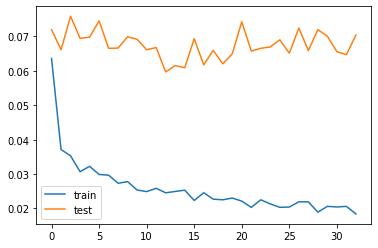

(76, 7)
(76, 7)
(76, 7)
score_train: [15.253] 14.4, 15.1, 15.4, 16.0, 16.5, 14.9, 14.4
(15, 1, 10)
score_test: [31.046] 26.7, 43.4, 46.6, 33.4, 12.1, 19.7, 18.2

RMSE test:  31.045855469484582 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0579 - val_loss: 0.0649
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0327 - val_loss: 0.0673
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0344 - val_loss: 0.0649
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0313 - val_loss: 0.0633
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.0651
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0275 - val_loss: 0.0652
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0291 - val_loss: 0.0644
Epoch 8/1000
76/76 [===================

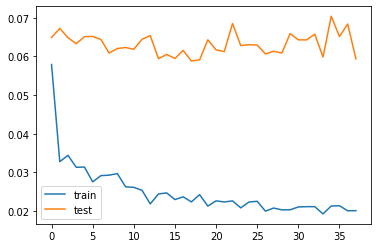

(76, 7)
(76, 7)
(76, 7)
score_train: [15.986] 14.2, 15.8, 17.3, 16.7, 16.7, 16.5, 14.5
(15, 1, 10)
score_test: [28.511] 21.6, 37.2, 43.3, 33.1, 11.3, 17.6, 20.8

RMSE test:  28.510954836337216 


Units CNN1:  111 Units CNN2:  61 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0772 - val_loss: 0.0558
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0341 - val_loss: 0.0638
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0336 - val_loss: 0.0570
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0305 - val_loss: 0.0594
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 0.0545
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.0538
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.0559
Epoch 8/1000
76/76 [====================

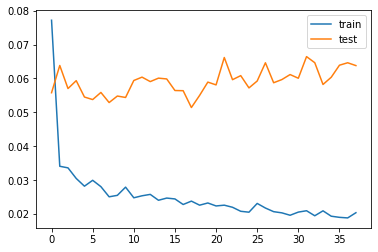

(76, 7)
(76, 7)
(76, 7)
score_train: [15.022] 14.4, 15.2, 15.6, 15.4, 15.4, 14.6, 14.5
(15, 1, 10)
score_test: [29.554] 25.3, 44.4, 44.5, 28.3, 17.3, 10.8, 17.3

RMSE test:  29.553811663838157 


Units CNN1:  95 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0726 - val_loss: 0.0666
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0402 - val_loss: 0.0716
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0397 - val_loss: 0.0620
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0316 - val_loss: 0.0668
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0312 - val_loss: 0.0708
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0346 - val_loss: 0.0638
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0330 - val_loss: 0.0651
Epoch 8/1000
76/76 [====================

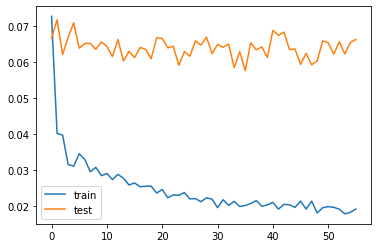

(76, 7)
(76, 7)
(76, 7)
score_train: [15.355] 14.3, 15.0, 15.5, 16.2, 16.0, 15.4, 14.9
(15, 1, 10)
score_test: [30.103] 22.1, 39.8, 48.5, 22.2, 21.9, 20.1, 23.3

RMSE test:  30.103473373160135 


Units CNN1:  111 Units CNN2:  126 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.0688 - val_loss: 0.0636
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0354 - val_loss: 0.0666
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0329 - val_loss: 0.0661
Epoch 4/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0329 - val_loss: 0.0661
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0320 - val_loss: 0.0636
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0298 - val_loss: 0.0661
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.0633
Epoch 8/1000
76/76 [===================

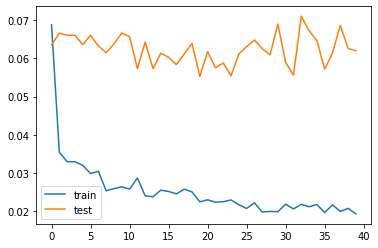

(76, 7)
(76, 7)
(76, 7)
score_train: [15.859] 15.2, 15.7, 15.7, 16.7, 16.0, 15.2, 16.4
(15, 1, 10)
score_test: [29.136] 25.8, 36.3, 45.6, 34.4, 11.4, 14.5, 19.0

RMSE test:  29.135825457413794 


Units CNN1:  111 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.0624 - val_loss: 0.0647
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0385 - val_loss: 0.0648
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0346 - val_loss: 0.0708
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0323 - val_loss: 0.0669
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0309 - val_loss: 0.0697
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0337 - val_loss: 0.0672
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0315 - val_loss: 0.0689
Epoch 8/1000
76/76 [===================

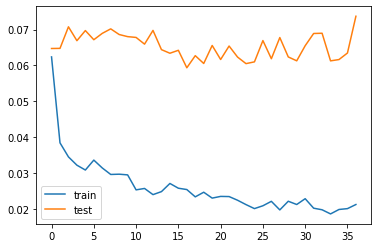

(76, 7)
(76, 7)
(76, 7)
score_train: [15.467] 14.2, 15.9, 15.6, 15.9, 16.0, 15.3, 15.2
(15, 1, 10)
score_test: [31.763] 26.0, 46.5, 49.7, 27.2, 16.6, 20.4, 17.8

RMSE test:  31.763201328671464 


Units CNN1:  127 Units CNN2:  125 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.0736 - val_loss: 0.0505
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0415 - val_loss: 0.0500
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0331 - val_loss: 0.0576
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0331 - val_loss: 0.0604
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.0648
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0303 - val_loss: 0.0611
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0269 - val_loss: 0.0654
Epoch 8/1000
76/76 [===================

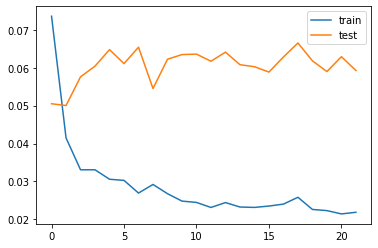

(76, 7)
(76, 7)
(76, 7)
score_train: [15.828] 14.2, 15.9, 15.8, 16.6, 16.3, 15.9, 16.0
(15, 1, 10)
score_test: [28.480] 23.3, 35.4, 44.6, 30.3, 18.5, 21.1, 13.6

RMSE test:  28.479814392138447 


Units CNN1:  111 Units CNN2:  119 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0691 - val_loss: 0.0709
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0347 - val_loss: 0.0666
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0354 - val_loss: 0.0693
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0341 - val_loss: 0.0671
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0301 - val_loss: 0.0675
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0322 - val_loss: 0.0654
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0312 - val_loss: 0.0665
Epoch 8/1000
76/76 [===================

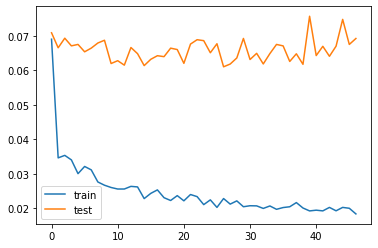

(76, 7)
(76, 7)
(76, 7)
score_train: [14.928] 14.1, 14.9, 15.4, 15.7, 15.5, 14.6, 14.2
(15, 1, 10)
score_test: [30.791] 29.6, 42.0, 46.8, 31.2, 16.1, 13.7, 19.6

RMSE test:  30.791127252798674 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0765 - val_loss: 0.0684
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0358 - val_loss: 0.0686
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0345 - val_loss: 0.0707
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.0782
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0316 - val_loss: 0.0687
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0289 - val_loss: 0.0691
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0302 - val_loss: 0.0717
Epoch 8/1000
76/76 [===================

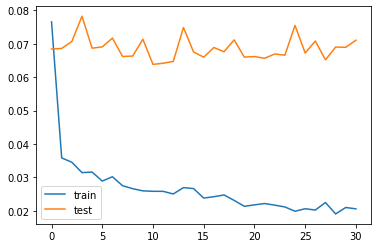

(76, 7)
(76, 7)
(76, 7)
score_train: [15.711] 14.5, 15.2, 16.0, 15.8, 15.9, 15.2, 17.3
(15, 1, 10)
score_test: [31.189] 26.5, 41.9, 48.3, 27.4, 15.1, 23.8, 21.8

RMSE test:  31.18897465402314 


Units CNN1:  127 Units CNN2:  61 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0668 - val_loss: 0.0560
Epoch 2/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0622
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0307 - val_loss: 0.0683
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.0695
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0319 - val_loss: 0.0602
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0310 - val_loss: 0.0609
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0289 - val_loss: 0.0637
Epoch 8/1000
76/76 [=====================

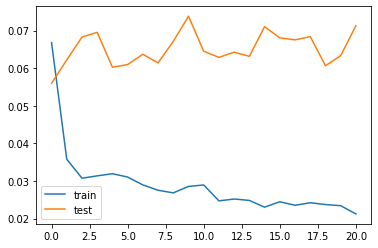

(76, 7)
(76, 7)
(76, 7)
score_train: [15.941] 14.9, 15.8, 15.9, 16.4, 16.4, 16.0, 16.2
(15, 1, 10)
score_test: [31.236] 27.6, 41.6, 49.7, 29.1, 17.1, 18.9, 19.4

RMSE test:  31.23581689928722 

gen	nevals	avg   	std     	min    	max    
0  	10    	28.752	0.764763	28.4798	31.0459

Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0568 - val_loss: 0.0616
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0329 - val_loss: 0.0593
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0341 - val_loss: 0.0629
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0327 - val_loss: 0.0703
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0319 - val_loss: 0.0668
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0291 - val_loss: 0.0565
Epoch 7/1000
76/76 [==============================] - 

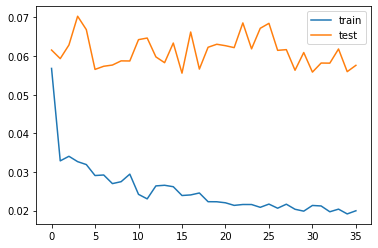

(76, 7)
(76, 7)
(76, 7)
score_train: [15.132] 14.5, 15.4, 15.5, 15.5, 15.7, 14.6, 14.7
(15, 1, 10)
score_test: [28.081] 26.2, 38.0, 44.7, 28.6, 15.4, 10.4, 15.2

RMSE test:  28.08061129563065 


Units CNN1:  94 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.0795 - val_loss: 0.0724
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0389 - val_loss: 0.0679
Epoch 3/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0330 - val_loss: 0.0723
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0776
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0329 - val_loss: 0.0664
Epoch 6/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0304 - val_loss: 0.0635
Epoch 7/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0290 - val_loss: 0.0653
Epoch 8/1000
76/76 [=====================

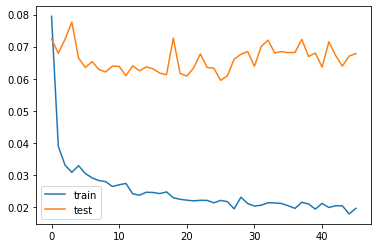

(76, 7)
(76, 7)
(76, 7)
score_train: [14.776] 13.8, 15.0, 15.3, 15.5, 15.3, 14.6, 13.8
(15, 1, 10)
score_test: [30.475] 24.4, 44.0, 48.5, 29.1, 17.2, 16.0, 14.9

RMSE test:  30.474982593690804 


Units CNN1:  111 Units CNN2:  119 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0664 - val_loss: 0.0547
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0356 - val_loss: 0.0563
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0352 - val_loss: 0.0636
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0316 - val_loss: 0.0595
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0301 - val_loss: 0.0613
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.0595
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0300 - val_loss: 0.0546
Epoch 8/1000
76/76 [===================

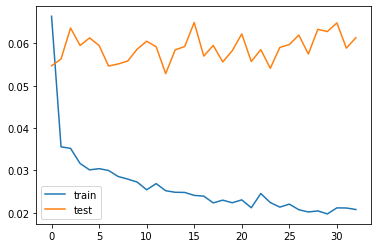

(76, 7)
(76, 7)
(76, 7)
score_train: [15.546] 14.0, 15.2, 15.5, 16.4, 16.6, 15.6, 15.3
(15, 1, 10)
score_test: [28.978] 23.8, 40.4, 43.8, 32.9, 10.8, 14.9, 18.4

RMSE test:  28.97777272562546 


Units CNN1:  111 Units CNN2:  119 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0749 - val_loss: 0.0728
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0409 - val_loss: 0.0744
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0366 - val_loss: 0.0657
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0327 - val_loss: 0.0703
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0298 - val_loss: 0.0764
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.0681
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.0667
Epoch 8/1000
76/76 [====================

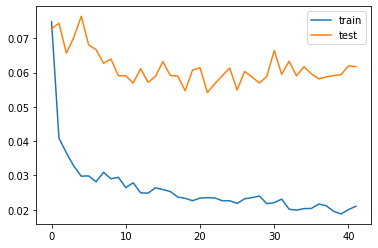

(76, 7)
(76, 7)
(76, 7)
score_train: [15.167] 14.5, 15.2, 15.3, 15.6, 15.6, 15.2, 14.6
(15, 1, 10)
score_test: [29.076] 23.2, 41.5, 45.5, 26.3, 16.8, 16.9, 18.1

RMSE test:  29.07559501924499 


Units CNN1:  126 Units CNN2:  125 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 6ms/step - loss: 0.0745 - val_loss: 0.0572
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0364 - val_loss: 0.0615
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0326 - val_loss: 0.0587
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0335 - val_loss: 0.0609
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0313 - val_loss: 0.0616
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.0628
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0301 - val_loss: 0.0614
Epoch 8/1000
76/76 [====================

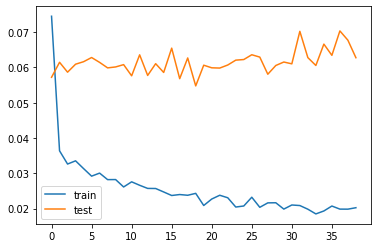

(76, 7)
(76, 7)
(76, 7)
score_train: [15.127] 14.5, 14.8, 15.6, 15.6, 15.9, 14.8, 14.5
(15, 1, 10)
score_test: [29.312] 23.9, 39.1, 44.2, 31.2, 17.0, 18.5, 18.9

RMSE test:  29.31171588052674 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0738 - val_loss: 0.0676
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0383 - val_loss: 0.0689
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0342 - val_loss: 0.0711
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0322 - val_loss: 0.0738
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0320 - val_loss: 0.0748
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.0658
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.0674
Epoch 8/1000
76/76 [====================

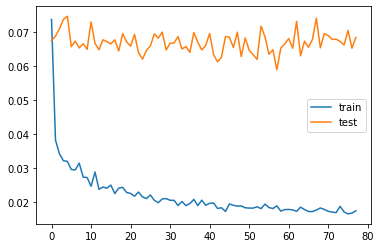

(76, 7)
(76, 7)
(76, 7)
score_train: [14.064] 13.0, 13.9, 14.7, 14.7, 15.1, 13.6, 13.3
(15, 1, 10)
score_test: [30.635] 27.6, 43.7, 47.9, 27.6, 15.9, 12.9, 20.3

RMSE test:  30.635319331228466 


Units CNN1:  117 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0706 - val_loss: 0.0561
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0383 - val_loss: 0.0692
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0340 - val_loss: 0.0682
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0318 - val_loss: 0.0706
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0334 - val_loss: 0.0712
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.0655
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0313 - val_loss: 0.0651
Epoch 8/1000
76/76 [===================

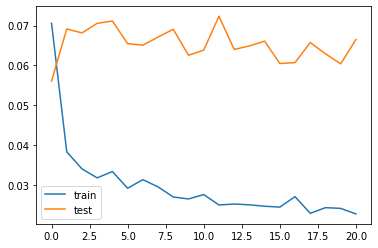

(76, 7)
(76, 7)
(76, 7)
score_train: [16.156] 14.9, 16.1, 16.1, 16.5, 16.8, 16.3, 16.3
(15, 1, 10)
score_test: [30.175] 27.6, 38.3, 50.0, 29.6, 18.6, 12.6, 16.2

RMSE test:  30.175247275486537 

1  	7     	28.4601	0.877336	28.0806	31.0459

Units CNN1:  125 Units CNN2:  119 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0736 - val_loss: 0.0643
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0356 - val_loss: 0.0685
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0324 - val_loss: 0.0636
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0312 - val_loss: 0.0628
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0319 - val_loss: 0.0653
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0272 - val_loss: 0.0665
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0283 - val_loss: 0.

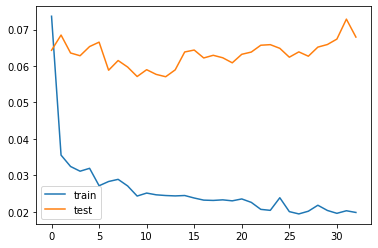

(76, 7)
(76, 7)
(76, 7)
score_train: [15.992] 14.8, 15.7, 17.2, 16.5, 16.1, 16.2, 15.3
(15, 1, 10)
score_test: [30.493] 28.7, 42.7, 46.7, 34.3, 13.2, 8.7, 16.1

RMSE test:  30.492518680510358 


Units CNN1:  126 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0672 - val_loss: 0.0577
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0357 - val_loss: 0.0615
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0322 - val_loss: 0.0623
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0320 - val_loss: 0.0599
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.0655
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0298 - val_loss: 0.0623
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0286 - val_loss: 0.0646
Epoch 8/1000
76/76 [====================

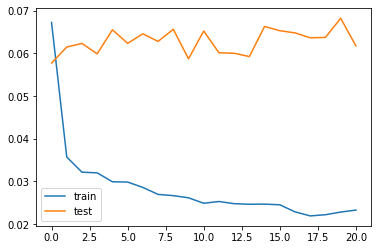

(76, 7)
(76, 7)
(76, 7)
score_train: [16.066] 15.0, 16.2, 16.0, 16.0, 16.8, 16.1, 16.3
(15, 1, 10)
score_test: [29.068] 28.2, 39.7, 45.8, 26.6, 13.2, 17.2, 16.4

RMSE test:  29.06840324664792 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0798 - val_loss: 0.0551
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0360 - val_loss: 0.0618
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0339 - val_loss: 0.0595
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0315 - val_loss: 0.0657
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0309 - val_loss: 0.0644
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0338 - val_loss: 0.0633
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.0670
Epoch 8/1000
76/76 [====================

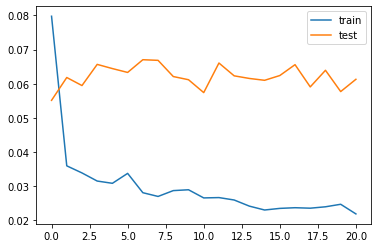

(76, 7)
(76, 7)
(76, 7)
score_train: [16.023] 14.9, 15.9, 16.0, 16.5, 16.5, 16.1, 16.2
(15, 1, 10)
score_test: [28.970] 25.8, 36.1, 45.7, 31.7, 20.2, 10.9, 17.0

RMSE test:  28.969529124205913 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0752 - val_loss: 0.0453
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0347 - val_loss: 0.0517
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0322 - val_loss: 0.0538
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0311 - val_loss: 0.0524
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0326 - val_loss: 0.0593
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.0584
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0312 - val_loss: 0.0622
Epoch 8/1000
76/76 [===================

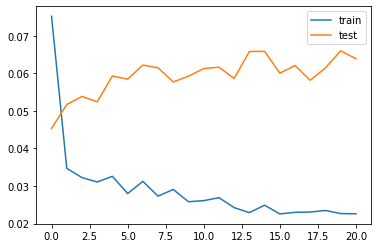

(76, 7)
(76, 7)
(76, 7)
score_train: [15.826] 14.5, 15.6, 16.2, 16.0, 16.7, 15.7, 15.9
(15, 1, 10)
score_test: [29.568] 25.5, 38.6, 46.9, 29.0, 15.0, 17.9, 19.6

RMSE test:  29.568017322724636 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0731 - val_loss: 0.0607
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0346 - val_loss: 0.0609
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0359 - val_loss: 0.0598
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0637
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0683
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.0629
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0289 - val_loss: 0.0625
Epoch 8/1000
76/76 [===================

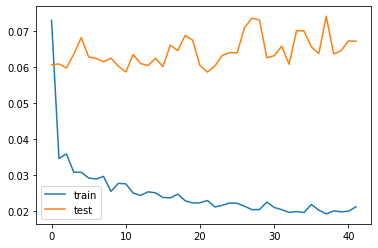

(76, 7)
(76, 7)
(76, 7)
score_train: [15.065] 14.2, 15.2, 15.4, 15.8, 15.3, 15.0, 14.4
(15, 1, 10)
score_test: [30.343] 25.5, 45.2, 48.2, 24.8, 13.3, 17.9, 17.8

RMSE test:  30.343362341256384 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0604 - val_loss: 0.0658
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0353 - val_loss: 0.0677
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0328 - val_loss: 0.0693
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0334 - val_loss: 0.0667
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0316 - val_loss: 0.0667
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0316 - val_loss: 0.0624
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0294 - val_loss: 0.0609
Epoch 8/1000
76/76 [===================

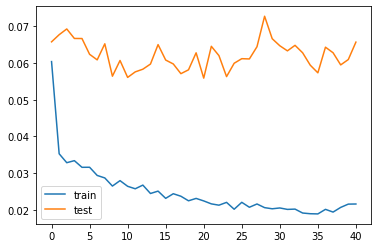

(76, 7)
(76, 7)
(76, 7)
score_train: [15.120] 14.0, 15.1, 15.5, 15.7, 15.5, 15.1, 14.8
(15, 1, 10)
score_test: [29.988] 27.0, 39.6, 47.4, 25.5, 14.1, 22.0, 20.4

RMSE test:  29.988173313520363 


Units CNN1:  111 Units CNN2:  119 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0778 - val_loss: 0.0638
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0354 - val_loss: 0.0665
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0330 - val_loss: 0.0678
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0336 - val_loss: 0.0703
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0328 - val_loss: 0.0696
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0289 - val_loss: 0.0683
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.0622
Epoch 8/1000
76/76 [===================

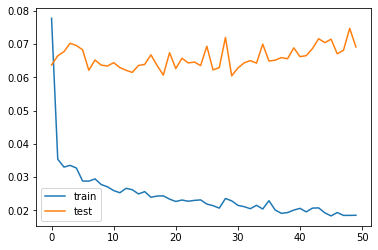

(76, 7)
(76, 7)
(76, 7)
score_train: [15.191] 14.5, 15.2, 16.0, 15.4, 15.7, 14.9, 14.7
(15, 1, 10)
score_test: [30.771] 19.8, 46.1, 47.9, 28.5, 16.5, 16.7, 21.1

RMSE test:  30.771464217713937 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0688 - val_loss: 0.0690
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0370 - val_loss: 0.0660
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0362 - val_loss: 0.0676
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0327 - val_loss: 0.0625
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.0606
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.0644
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.0610
Epoch 8/1000
76/76 [===================

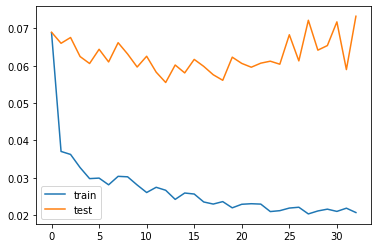

(76, 7)
(76, 7)
(76, 7)
score_train: [17.410] 14.9, 17.4, 16.4, 18.7, 17.9, 18.4, 17.8
(15, 1, 10)
score_test: [31.669] 23.3, 41.8, 50.8, 18.6, 22.2, 24.3, 26.8

RMSE test:  31.669438827121642 


Units CNN1:  127 Units CNN2:  119 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0540 - val_loss: 0.0536
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0372 - val_loss: 0.0600
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0324 - val_loss: 0.0621
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0301 - val_loss: 0.0660
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0286 - val_loss: 0.0648
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0648
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0610
Epoch 8/1000
76/76 [===================

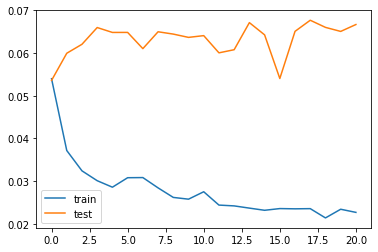

(76, 7)
(76, 7)
(76, 7)
score_train: [16.283] 15.5, 16.1, 16.1, 16.5, 16.7, 16.9, 16.2
(15, 1, 10)
score_test: [30.213] 24.9, 41.5, 47.6, 23.5, 19.3, 21.3, 20.0

RMSE test:  30.213234237059698 

2  	9     	28.1236	0.129103	28.0806	28.511 

Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0652 - val_loss: 0.0543
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0366 - val_loss: 0.0583
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0320 - val_loss: 0.0604
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0330 - val_loss: 0.0658
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.0604
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0289 - val_loss: 0.0598
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.

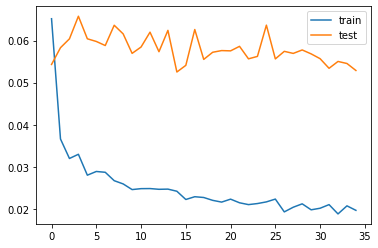

(76, 7)
(76, 7)
(76, 7)
score_train: [16.347] 14.7, 17.1, 16.8, 17.1, 16.5, 15.7, 16.4
(15, 1, 10)
score_test: [26.906] 21.7, 37.4, 38.7, 35.8, 14.0, 11.2, 10.0

RMSE test:  26.90640105187532 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0732 - val_loss: 0.0641
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0341 - val_loss: 0.0642
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0332 - val_loss: 0.0697
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0321 - val_loss: 0.0668
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0313 - val_loss: 0.0720
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.0645
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0283 - val_loss: 0.0648
Epoch 8/1000
76/76 [====================

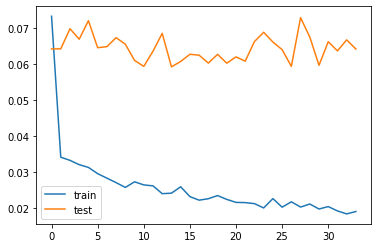

(76, 7)
(76, 7)
(76, 7)
score_train: [15.034] 14.5, 15.0, 15.2, 15.7, 15.5, 14.7, 14.6
(15, 1, 10)
score_test: [29.621] 23.4, 41.8, 46.1, 28.4, 13.2, 16.5, 21.6

RMSE test:  29.62121145846234 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0826 - val_loss: 0.0674
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0368 - val_loss: 0.0671
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0344 - val_loss: 0.0703
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0310 - val_loss: 0.0696
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0307 - val_loss: 0.0643
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0307 - val_loss: 0.0651
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.0645
Epoch 8/1000
76/76 [====================

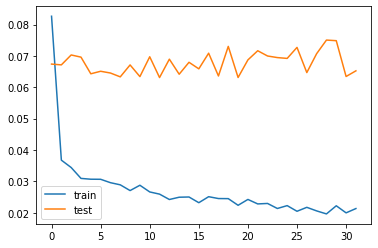

(76, 7)
(76, 7)
(76, 7)
score_train: [15.563] 15.0, 15.3, 16.2, 15.8, 16.0, 15.5, 15.1
(15, 1, 10)
score_test: [29.885] 23.2, 45.7, 43.5, 29.7, 16.9, 15.5, 18.1

RMSE test:  29.885068993779544 


Units CNN1:  63 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 6ms/step - loss: 0.1249 - val_loss: 0.0685
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0442 - val_loss: 0.0597
Epoch 3/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0650
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0380 - val_loss: 0.0640
Epoch 5/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0374 - val_loss: 0.0669
Epoch 6/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0360 - val_loss: 0.0654
Epoch 7/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0336 - val_loss: 0.0665
Epoch 8/1000
76/76 [====================

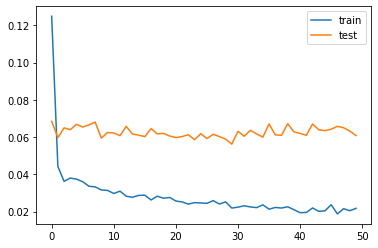

(76, 7)
(76, 7)
(76, 7)
score_train: [15.423] 14.8, 15.5, 15.5, 15.9, 16.1, 15.1, 15.1
(15, 1, 10)
score_test: [28.855] 26.0, 37.6, 44.5, 30.5, 17.2, 18.9, 13.1

RMSE test:  28.85535132615955 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.0685 - val_loss: 0.0766
Epoch 2/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0695
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0366 - val_loss: 0.0770
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0337 - val_loss: 0.0784
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0311 - val_loss: 0.0771
Epoch 6/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0280 - val_loss: 0.0752
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0298 - val_loss: 0.0698
Epoch 8/1000
76/76 [====================

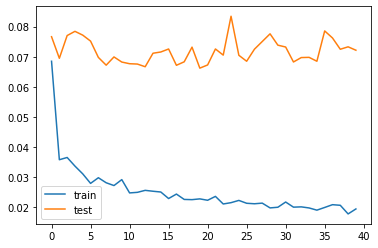

(76, 7)
(76, 7)
(76, 7)
score_train: [15.015] 14.0, 15.0, 15.7, 15.8, 15.7, 14.7, 14.3
(15, 1, 10)
score_test: [31.425] 23.7, 44.9, 48.4, 33.4, 17.0, 15.1, 18.9

RMSE test:  31.42494691152414 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0613 - val_loss: 0.0579
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0341 - val_loss: 0.0613
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0319 - val_loss: 0.0643
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0328 - val_loss: 0.0618
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0291 - val_loss: 0.0647
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0254 - val_loss: 0.0617
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0266 - val_loss: 0.0646
Epoch 8/1000
76/76 [====================

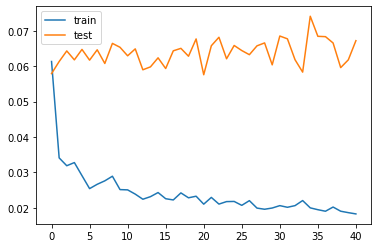

(76, 7)
(76, 7)
(76, 7)
score_train: [14.910] 13.3, 15.3, 15.2, 15.9, 15.6, 14.5, 14.3
(15, 1, 10)
score_test: [30.325] 22.6, 43.8, 45.4, 31.8, 12.9, 20.7, 18.4

RMSE test:  30.325229067964845 


Units CNN1:  127 Units CNN2:  119 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0823 - val_loss: 0.0552
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0390 - val_loss: 0.0572
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0340 - val_loss: 0.0638
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0339 - val_loss: 0.0593
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0316 - val_loss: 0.0616
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0305 - val_loss: 0.0595
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.0602
Epoch 8/1000
76/76 [===================

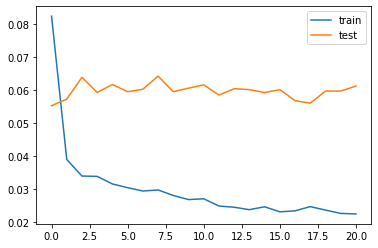

(76, 7)
(76, 7)
(76, 7)
score_train: [16.003] 14.5, 15.9, 16.0, 16.0, 16.5, 16.6, 16.4
(15, 1, 10)
score_test: [28.934] 23.2, 38.1, 45.6, 28.0, 18.1, 19.1, 17.7

RMSE test:  28.934254960921333 


Units CNN1:  111 Units CNN2:  61 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.0721 - val_loss: 0.0711
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0348 - val_loss: 0.0669
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0379 - val_loss: 0.0689
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0344 - val_loss: 0.0683
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0333 - val_loss: 0.0718
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0301 - val_loss: 0.0676
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0279 - val_loss: 0.0661
Epoch 8/1000
76/76 [====================

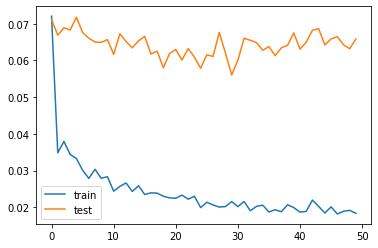

(76, 7)
(76, 7)
(76, 7)
score_train: [14.664] 13.6, 14.8, 15.5, 15.7, 15.1, 14.2, 13.6
(15, 1, 10)
score_test: [30.023] 24.6, 42.3, 44.1, 35.3, 17.0, 13.8, 15.7

RMSE test:  30.02256694911539 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0748 - val_loss: 0.0684
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0375 - val_loss: 0.0639
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0342 - val_loss: 0.0715
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0326 - val_loss: 0.0664
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0328 - val_loss: 0.0665
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0303 - val_loss: 0.0612
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.0672
Epoch 8/1000
76/76 [====================

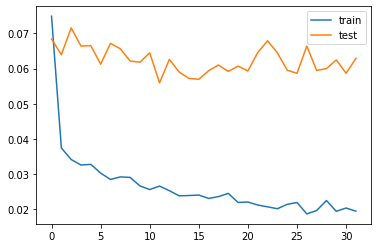

(76, 7)
(76, 7)
(76, 7)
score_train: [15.169] 14.4, 15.0, 15.4, 15.8, 15.8, 14.8, 14.8
(15, 1, 10)
score_test: [29.341] 26.1, 40.1, 45.6, 31.6, 13.1, 14.0, 17.1

RMSE test:  29.341306964044826 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0728 - val_loss: 0.0523
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0370 - val_loss: 0.0603
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0351 - val_loss: 0.0620
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0576
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0329 - val_loss: 0.0656
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.0597
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.0593
Epoch 8/1000
76/76 [===================

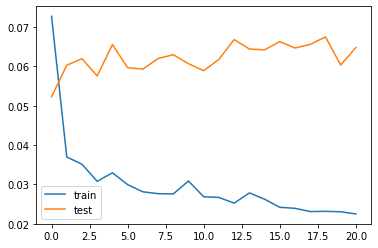

(76, 7)
(76, 7)
(76, 7)
score_train: [16.166] 15.0, 15.9, 16.2, 17.1, 16.4, 16.0, 16.4
(15, 1, 10)
score_test: [29.788] 25.7, 39.7, 49.3, 25.6, 15.1, 18.5, 17.9

RMSE test:  29.787900402246194 

3  	10    	26.9064	0       	26.9064	26.9064

Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.0730 - val_loss: 0.0556
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0356 - val_loss: 0.0562
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0331 - val_loss: 0.0557
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0346 - val_loss: 0.0583
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0317 - val_loss: 0.0619
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.0582
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0343 - val_loss: 0.

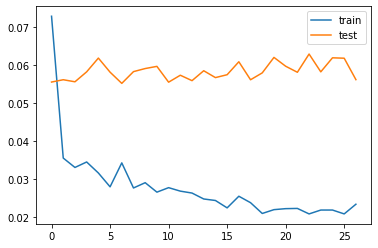

(76, 7)
(76, 7)
(76, 7)
score_train: [15.680] 14.4, 16.2, 15.5, 16.3, 16.0, 15.6, 15.7
(15, 1, 10)
score_test: [27.751] 22.3, 35.7, 46.6, 26.7, 16.6, 13.7, 16.3

RMSE test:  27.750635152964673 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 7ms/step - loss: 0.0572 - val_loss: 0.0538
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0348 - val_loss: 0.0605
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0366 - val_loss: 0.0623
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0321 - val_loss: 0.0661
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0303 - val_loss: 0.0658
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0313 - val_loss: 0.0633
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0284 - val_loss: 0.0654
Epoch 8/1000
76/76 [===================

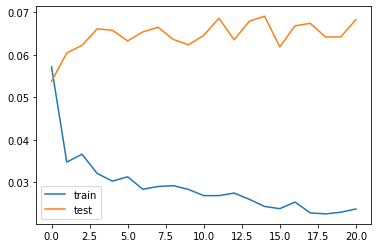

(76, 7)
(76, 7)
(76, 7)
score_train: [16.493] 15.2, 16.3, 16.2, 17.1, 16.7, 17.2, 16.6
(15, 1, 10)
score_test: [30.578] 23.6, 41.2, 48.2, 24.2, 19.1, 24.3, 20.5

RMSE test:  30.577713367766343 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0750 - val_loss: 0.0612
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0370 - val_loss: 0.0631
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0371 - val_loss: 0.0733
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0351 - val_loss: 0.0613
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0298 - val_loss: 0.0617
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0627
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0277 - val_loss: 0.0709
Epoch 8/1000
76/76 [===================

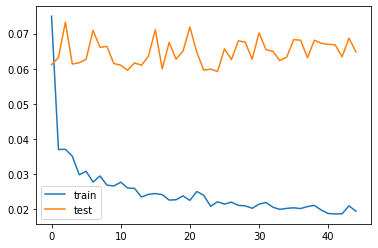

(76, 7)
(76, 7)
(76, 7)
score_train: [14.831] 13.9, 15.0, 15.2, 15.5, 15.2, 14.6, 14.3
(15, 1, 10)
score_test: [29.778] 23.4, 38.6, 46.8, 27.6, 18.1, 21.0, 21.3

RMSE test:  29.778416702035674 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.0689 - val_loss: 0.0641
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0362 - val_loss: 0.0681
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0350 - val_loss: 0.0619
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0321 - val_loss: 0.0664
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0320 - val_loss: 0.0693
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.0692
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0277 - val_loss: 0.0756
Epoch 8/1000
76/76 [===================

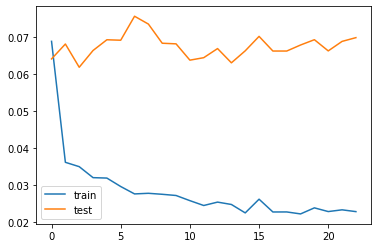

(76, 7)
(76, 7)
(76, 7)
score_train: [15.924] 15.0, 15.8, 16.1, 16.4, 16.3, 16.2, 15.7
(15, 1, 10)
score_test: [30.921] 31.4, 41.0, 48.4, 27.8, 16.4, 19.4, 16.3

RMSE test:  30.92129123445097 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0643 - val_loss: 0.0649
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0351 - val_loss: 0.0674
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0329 - val_loss: 0.0653
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0319 - val_loss: 0.0710
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.0747
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.0659
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0284 - val_loss: 0.0637
Epoch 8/1000
76/76 [====================

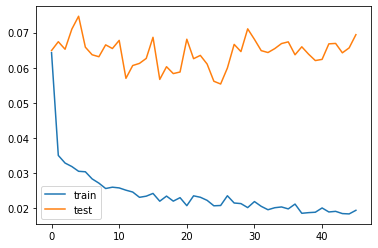

(76, 7)
(76, 7)
(76, 7)
score_train: [15.669] 14.1, 16.0, 15.6, 16.8, 16.5, 15.3, 15.1
(15, 1, 10)
score_test: [30.829] 27.8, 42.3, 45.9, 36.2, 15.2, 10.5, 18.2

RMSE test:  30.8288532781474 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.0876 - val_loss: 0.0640
Epoch 2/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0360 - val_loss: 0.0657
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0320 - val_loss: 0.0663
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0340 - val_loss: 0.0676
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0628
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.0597
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0336 - val_loss: 0.0610
Epoch 8/1000
76/76 [=====================

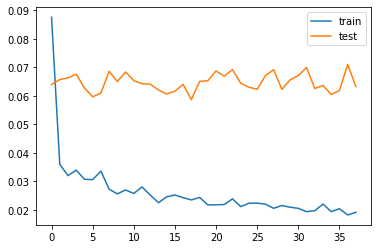

(76, 7)
(76, 7)
(76, 7)
score_train: [15.079] 14.3, 15.3, 15.6, 15.8, 15.6, 14.5, 14.4
(15, 1, 10)
score_test: [29.423] 23.7, 38.7, 46.6, 30.5, 14.0, 18.3, 19.3

RMSE test:  29.42300424971975 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.0530 - val_loss: 0.0540
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0373 - val_loss: 0.0555
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.0623
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0328 - val_loss: 0.0673
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0326 - val_loss: 0.0614
Epoch 6/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.0651
Epoch 7/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0306 - val_loss: 0.0611
Epoch 8/1000
76/76 [====================

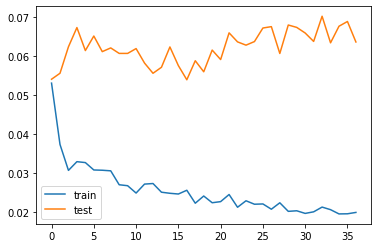

(76, 7)
(76, 7)
(76, 7)
score_train: [15.662] 14.2, 15.7, 16.1, 16.3, 17.1, 14.8, 15.3
(15, 1, 10)
score_test: [29.501] 25.4, 44.0, 43.5, 31.9, 10.9, 14.2, 16.8

RMSE test:  29.500811932381293 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.0679 - val_loss: 0.0725
Epoch 2/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0380 - val_loss: 0.0678
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0339 - val_loss: 0.0635
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.0695
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0310 - val_loss: 0.0712
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.0688
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0291 - val_loss: 0.0671
Epoch 8/1000
76/76 [===================

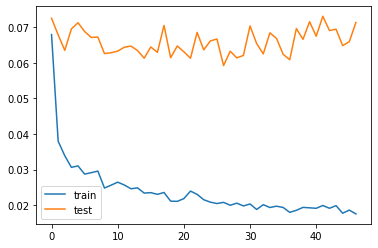

(76, 7)
(76, 7)
(76, 7)
score_train: [14.558] 13.8, 14.9, 15.2, 15.2, 15.1, 13.8, 13.8
(15, 1, 10)
score_test: [31.239] 31.7, 44.1, 45.3, 31.3, 21.7, 10.7, 16.2

RMSE test:  31.2391409663239 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.0831 - val_loss: 0.0559
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0382 - val_loss: 0.0600
Epoch 3/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0368 - val_loss: 0.0616
Epoch 4/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0696
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0327 - val_loss: 0.0637
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.0685
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.0652
Epoch 8/1000
76/76 [=====================

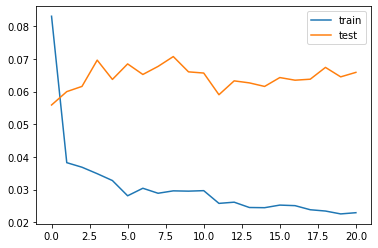

(76, 7)
(76, 7)
(76, 7)
score_train: [16.042] 15.3, 16.1, 16.3, 16.4, 16.4, 16.2, 15.6
(15, 1, 10)
score_test: [30.034] 25.7, 40.6, 48.0, 30.0, 14.8, 18.0, 16.0

RMSE test:  30.03363547582643 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 1s 7ms/step - loss: 0.0810 - val_loss: 0.0575
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0381 - val_loss: 0.0635
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0323 - val_loss: 0.0613
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0323 - val_loss: 0.0658
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0301 - val_loss: 0.0627
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0277 - val_loss: 0.0643
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0598
Epoch 8/1000
76/76 [====================

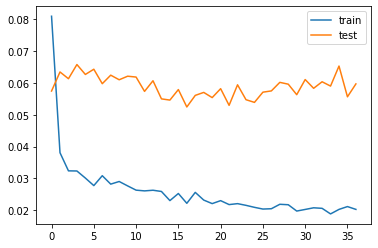

(76, 7)
(76, 7)
(76, 7)
score_train: [15.082] 13.9, 15.3, 15.8, 15.6, 15.5, 14.9, 14.3
(15, 1, 10)
score_test: [28.588] 19.5, 40.4, 45.5, 29.6, 17.1, 15.0, 15.8

RMSE test:  28.58773676149373 

4  	10    	26.9064	0       	26.9064	26.9064

Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0714 - val_loss: 0.0509
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0352 - val_loss: 0.0568
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0589
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0339 - val_loss: 0.0576
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0587
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0283 - val_loss: 0.0612
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.0

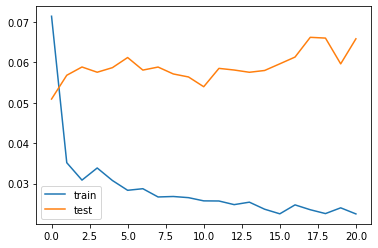

(76, 7)
(76, 7)
(76, 7)
score_train: [16.221] 14.9, 16.1, 16.6, 16.4, 16.9, 15.9, 16.6
(15, 1, 10)
score_test: [30.022] 24.5, 40.8, 48.2, 25.6, 18.7, 18.3, 19.5

RMSE test:  30.021650548105836 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0962 - val_loss: 0.0544
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0349 - val_loss: 0.0565
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0332 - val_loss: 0.0668
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0332 - val_loss: 0.0616
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0311 - val_loss: 0.0687
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0303 - val_loss: 0.0657
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0254 - val_loss: 0.0675
Epoch 8/1000
76/76 [===================

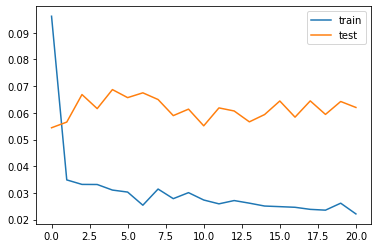

(76, 7)
(76, 7)
(76, 7)
score_train: [16.186] 14.7, 16.7, 16.1, 16.5, 16.7, 16.1, 16.4
(15, 1, 10)
score_test: [29.133] 23.4, 39.0, 46.5, 31.4, 16.7, 13.5, 16.3

RMSE test:  29.13271898961573 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0704 - val_loss: 0.0709
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0349 - val_loss: 0.0610
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0326 - val_loss: 0.0676
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0327 - val_loss: 0.0646
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0333 - val_loss: 0.0652
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0313 - val_loss: 0.0660
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0279 - val_loss: 0.0626
Epoch 8/1000
76/76 [====================

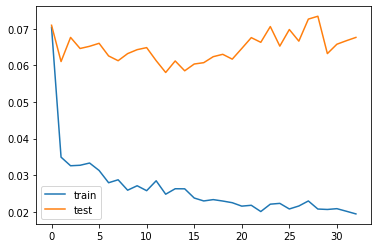

(76, 7)
(76, 7)
(76, 7)
score_train: [15.113] 14.1, 15.3, 15.3, 16.0, 15.6, 14.7, 14.8
(15, 1, 10)
score_test: [30.423] 23.2, 40.6, 47.7, 33.5, 19.0, 13.3, 19.0

RMSE test:  30.423190827846522 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.0631 - val_loss: 0.0613
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0335 - val_loss: 0.0649
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0354 - val_loss: 0.0647
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0303 - val_loss: 0.0650
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0321 - val_loss: 0.0659
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.0617
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0305 - val_loss: 0.0636
Epoch 8/1000
76/76 [===================

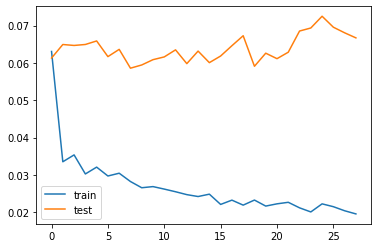

(76, 7)
(76, 7)
(76, 7)
score_train: [15.352] 14.5, 15.7, 15.6, 15.5, 16.0, 15.0, 15.2
(15, 1, 10)
score_test: [30.222] 24.9, 39.7, 45.5, 29.5, 14.7, 23.7, 21.9

RMSE test:  30.222194890612798 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.0702 - val_loss: 0.0558
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0347 - val_loss: 0.0585
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0342 - val_loss: 0.0601
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0335 - val_loss: 0.0579
Epoch 5/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0293 - val_loss: 0.0553
Epoch 6/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0298 - val_loss: 0.0626
Epoch 7/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0287 - val_loss: 0.0581
Epoch 8/1000
76/76 [===================

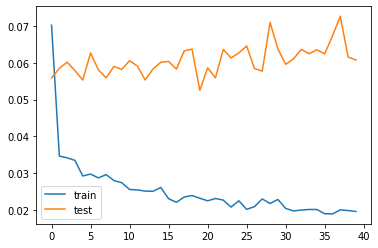

(76, 7)
(76, 7)
(76, 7)
score_train: [15.182] 14.7, 14.8, 15.5, 15.7, 15.4, 15.4, 14.8
(15, 1, 10)
score_test: [28.835] 16.7, 43.0, 44.1, 27.8, 16.1, 19.2, 18.7

RMSE test:  28.835328433695523 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.0628 - val_loss: 0.0583
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0381 - val_loss: 0.0597
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0339 - val_loss: 0.0646
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0346 - val_loss: 0.0642
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.0640
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.0567
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.0677
Epoch 8/1000
76/76 [===================

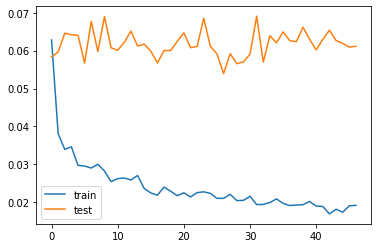

(76, 7)
(76, 7)
(76, 7)
score_train: [14.607] 13.8, 14.6, 15.1, 15.4, 15.3, 14.2, 13.7
(15, 1, 10)
score_test: [28.930] 25.2, 35.2, 47.0, 29.1, 20.0, 10.3, 20.4

RMSE test:  28.93031212227995 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.0770 - val_loss: 0.0595
Epoch 2/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0660
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0343 - val_loss: 0.0751
Epoch 4/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0334 - val_loss: 0.0736
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0325 - val_loss: 0.0721
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0307 - val_loss: 0.0705
Epoch 7/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0292 - val_loss: 0.0673
Epoch 8/1000
76/76 [====================

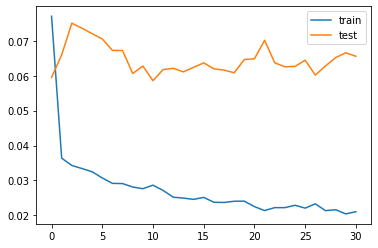

(76, 7)
(76, 7)
(76, 7)
score_train: [15.721] 15.3, 15.7, 15.5, 15.9, 15.9, 16.3, 15.6
(15, 1, 10)
score_test: [29.961] 24.2, 43.0, 46.1, 27.1, 15.5, 21.2, 17.3

RMSE test:  29.960977829184802 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 1s 7ms/step - loss: 0.0659 - val_loss: 0.0702
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0354 - val_loss: 0.0722
Epoch 3/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0638
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0331 - val_loss: 0.0704
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0301 - val_loss: 0.0688
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.0674
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0272 - val_loss: 0.0652
Epoch 8/1000
76/76 [===================

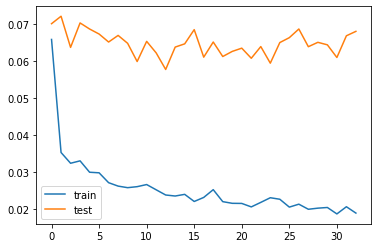

(76, 7)
(76, 7)
(76, 7)
score_train: [14.916] 13.9, 15.0, 15.4, 15.5, 15.5, 14.8, 14.3
(15, 1, 10)
score_test: [30.537] 26.5, 39.1, 49.4, 31.2, 15.3, 16.0, 19.8

RMSE test:  30.537387067655924 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0775 - val_loss: 0.0601
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0365 - val_loss: 0.0587
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0345 - val_loss: 0.0721
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0326 - val_loss: 0.0668
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0333 - val_loss: 0.0665
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0305 - val_loss: 0.0732
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0309 - val_loss: 0.0688
Epoch 8/1000
76/76 [===================

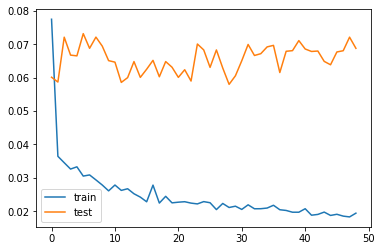

(76, 7)
(76, 7)
(76, 7)
score_train: [14.621] 13.9, 14.8, 14.8, 15.4, 15.2, 14.0, 14.1
(15, 1, 10)
score_test: [30.686] 24.2, 43.9, 48.0, 26.4, 14.5, 19.1, 22.3

RMSE test:  30.686489079294265 

5  	9     	26.9064	0       	26.9064	26.9064

Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0724 - val_loss: 0.0586
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0357 - val_loss: 0.0633
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0333 - val_loss: 0.0636
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0318 - val_loss: 0.0658
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.0647
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.0662
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0307 - val_loss: 0.

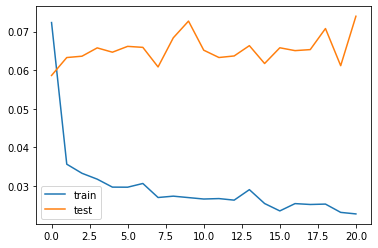

(76, 7)
(76, 7)
(76, 7)
score_train: [16.768] 15.0, 15.8, 17.3, 16.8, 16.9, 17.4, 17.9
(15, 1, 10)
score_test: [31.825] 24.9, 39.5, 50.4, 28.7, 18.4, 27.6, 21.1

RMSE test:  31.82548315279721 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0722 - val_loss: 0.0615
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0354 - val_loss: 0.0606
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0345 - val_loss: 0.0633
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0310 - val_loss: 0.0641
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0313 - val_loss: 0.0625
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.0686
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.0676
Epoch 8/1000
76/76 [====================

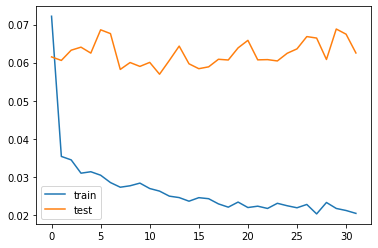

(76, 7)
(76, 7)
(76, 7)
score_train: [15.907] 14.1, 15.9, 15.9, 16.5, 17.6, 15.0, 16.2
(15, 1, 10)
score_test: [29.257] 22.7, 39.4, 45.7, 34.6, 13.6, 16.0, 14.2

RMSE test:  29.256983146003215 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.0760 - val_loss: 0.0580
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0327 - val_loss: 0.0685
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0345 - val_loss: 0.0586
Epoch 4/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0350 - val_loss: 0.0590
Epoch 5/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0299 - val_loss: 0.0623
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0294 - val_loss: 0.0605
Epoch 7/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0287 - val_loss: 0.0615
Epoch 8/1000
76/76 [===================

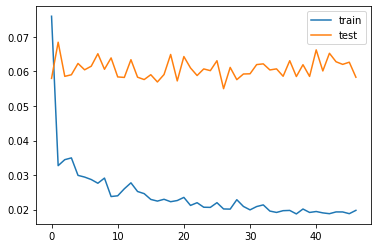

(76, 7)
(76, 7)
(76, 7)
score_train: [14.855] 13.7, 15.0, 15.5, 15.3, 16.1, 14.5, 13.7
(15, 1, 10)
score_test: [28.258] 25.7, 35.7, 43.7, 27.6, 19.8, 16.8, 17.5

RMSE test:  28.25791357824387 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0850 - val_loss: 0.0594
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0386 - val_loss: 0.0669
Epoch 3/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0637
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0310 - val_loss: 0.0681
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0325 - val_loss: 0.0669
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0686
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0270 - val_loss: 0.0654
Epoch 8/1000
76/76 [====================

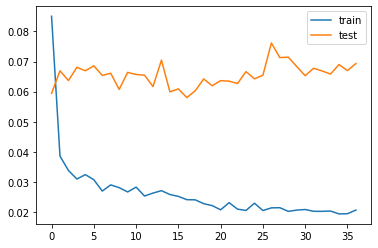

(76, 7)
(76, 7)
(76, 7)
score_train: [15.331] 14.0, 14.8, 15.2, 16.0, 16.2, 16.1, 14.9
(15, 1, 10)
score_test: [30.809] 29.1, 41.6, 46.9, 26.0, 16.4, 22.0, 20.8

RMSE test:  30.809402908852302 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.0773 - val_loss: 0.0574
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0325 - val_loss: 0.0605
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0327 - val_loss: 0.0648
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0333 - val_loss: 0.0612
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.0643
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.0625
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0294 - val_loss: 0.0599
Epoch 8/1000
76/76 [===================

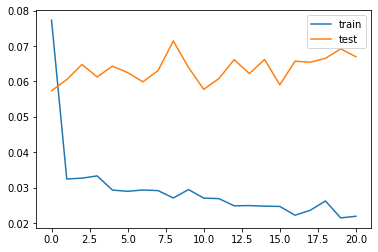

(76, 7)
(76, 7)
(76, 7)
score_train: [16.075] 14.6, 15.7, 16.1, 16.5, 17.0, 16.0, 16.4
(15, 1, 10)
score_test: [30.280] 24.5, 41.7, 48.5, 26.4, 18.9, 16.8, 19.9

RMSE test:  30.27986521403293 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.0648 - val_loss: 0.0575
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0356 - val_loss: 0.0594
Epoch 3/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.0625
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0316 - val_loss: 0.0631
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0338 - val_loss: 0.0651
Epoch 6/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0290 - val_loss: 0.0692
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.0645
Epoch 8/1000
76/76 [====================

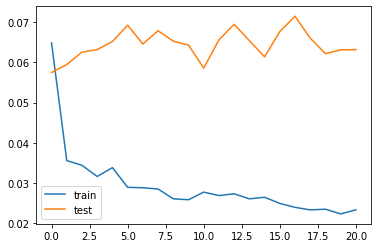

(76, 7)
(76, 7)
(76, 7)
score_train: [16.257] 14.7, 16.0, 16.3, 16.7, 16.9, 16.4, 16.8
(15, 1, 10)
score_test: [29.399] 27.5, 38.8, 44.6, 30.7, 18.5, 16.9, 14.9

RMSE test:  29.398739330974482 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 1s 8ms/step - loss: 0.0610 - val_loss: 0.0615
Epoch 2/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0359 - val_loss: 0.0629
Epoch 3/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0689
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0325 - val_loss: 0.0645
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.0639
Epoch 6/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0292 - val_loss: 0.0606
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0266 - val_loss: 0.0641
Epoch 8/1000
76/76 [===================

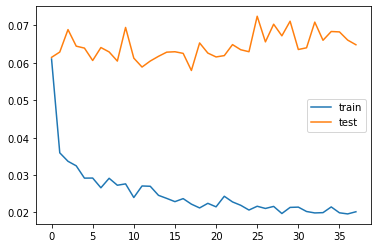

(76, 7)
(76, 7)
(76, 7)
score_train: [15.138] 14.1, 15.1, 16.2, 16.1, 15.4, 14.6, 14.4
(15, 1, 10)
score_test: [29.794] 22.5, 44.6, 44.6, 31.5, 15.1, 14.5, 17.4

RMSE test:  29.793744206424705 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0877 - val_loss: 0.0605
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0372 - val_loss: 0.0556
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0350 - val_loss: 0.0594
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0322 - val_loss: 0.0614
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0321 - val_loss: 0.0630
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0627
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0305 - val_loss: 0.0626
Epoch 8/1000
76/76 [===================

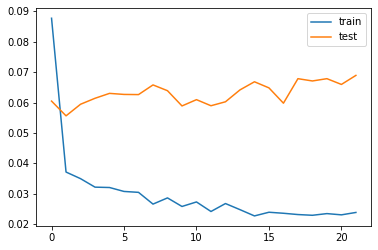

(76, 7)
(76, 7)
(76, 7)
score_train: [15.931] 14.5, 15.6, 16.0, 16.4, 16.8, 15.7, 16.4
(15, 1, 10)
score_test: [30.712] 25.0, 42.9, 48.7, 27.7, 16.4, 20.2, 17.9

RMSE test:  30.712267971928153 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0732 - val_loss: 0.0707
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0389 - val_loss: 0.0669
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0334 - val_loss: 0.0654
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0325 - val_loss: 0.0685
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0303 - val_loss: 0.0725
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.0683
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0276 - val_loss: 0.0672
Epoch 8/1000
76/76 [===================

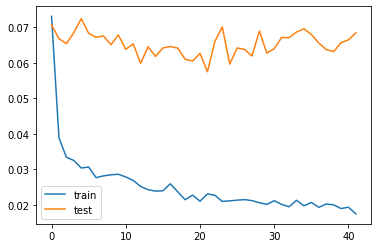

(76, 7)
(76, 7)
(76, 7)
score_train: [14.962] 14.1, 15.0, 15.2, 15.9, 15.4, 14.6, 14.6
(15, 1, 10)
score_test: [30.625] 26.6, 39.3, 48.6, 24.5, 19.7, 17.0, 25.9

RMSE test:  30.624834007675904 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0613 - val_loss: 0.0568
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0367 - val_loss: 0.0608
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0341 - val_loss: 0.0660
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0315 - val_loss: 0.0674
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0298 - val_loss: 0.0659
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.0611
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.0660
Epoch 8/1000
76/76 [===================

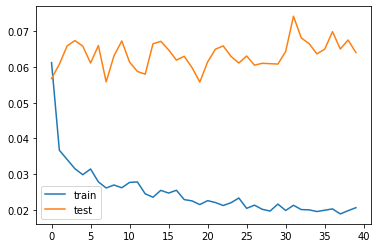

(76, 7)
(76, 7)
(76, 7)
score_train: [14.793] 13.8, 14.9, 15.3, 15.2, 15.4, 14.5, 14.4
(15, 1, 10)
score_test: [29.619] 24.3, 42.4, 46.4, 28.3, 17.7, 12.1, 18.5

RMSE test:  29.61932545459329 

6  	10    	26.9064	0       	26.9064	26.9064

Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.0539 - val_loss: 0.0687
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0323 - val_loss: 0.0693
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0337 - val_loss: 0.0741
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0312 - val_loss: 0.0685
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.0696
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0291 - val_loss: 0.0709
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.0

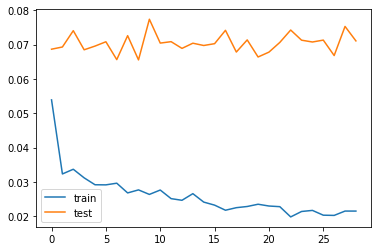

(76, 7)
(76, 7)
(76, 7)
score_train: [15.719] 14.8, 15.2, 15.6, 16.1, 16.4, 16.2, 15.6
(15, 1, 10)
score_test: [31.200] 29.3, 44.3, 46.6, 33.7, 20.4, 6.3, 15.3

RMSE test:  31.199963193487925 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0764 - val_loss: 0.0541
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0351 - val_loss: 0.0542
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0319 - val_loss: 0.0576
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0329 - val_loss: 0.0631
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0316 - val_loss: 0.0640
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0301 - val_loss: 0.0613
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0289 - val_loss: 0.0597
Epoch 8/1000
76/76 [====================

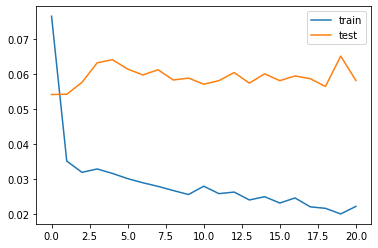

(76, 7)
(76, 7)
(76, 7)
score_train: [15.974] 14.8, 15.8, 16.0, 16.2, 16.4, 16.2, 16.4
(15, 1, 10)
score_test: [28.195] 27.1, 33.1, 46.0, 27.1, 17.7, 14.8, 18.6

RMSE test:  28.195026865460644 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0669 - val_loss: 0.0695
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0356 - val_loss: 0.0711
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0345 - val_loss: 0.0701
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0316 - val_loss: 0.0656
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0639
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.0668
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.0666
Epoch 8/1000
76/76 [===================

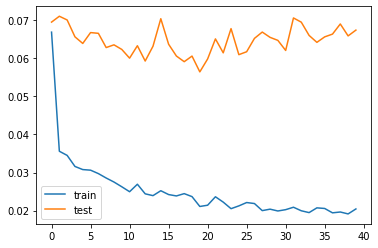

(76, 7)
(76, 7)
(76, 7)
score_train: [15.104] 15.5, 15.0, 15.6, 15.6, 15.4, 14.5, 14.1
(15, 1, 10)
score_test: [30.378] 23.6, 44.3, 48.1, 27.3, 19.1, 17.1, 14.7

RMSE test:  30.378061662389886 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0768 - val_loss: 0.0627
Epoch 2/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0596
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0331 - val_loss: 0.0611
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0323 - val_loss: 0.0572
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0327 - val_loss: 0.0624
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.0608
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.0589
Epoch 8/1000
76/76 [===================

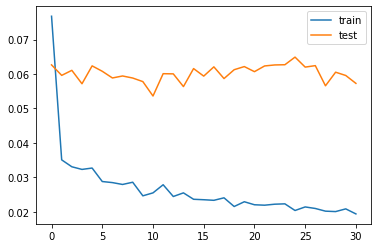

(76, 7)
(76, 7)
(76, 7)
score_train: [15.439] 14.1, 15.6, 15.7, 16.0, 16.0, 15.3, 15.2
(15, 1, 10)
score_test: [28.003] 22.9, 36.7, 42.7, 30.2, 13.6, 18.7, 18.7

RMSE test:  28.00306946384762 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.0962 - val_loss: 0.0556
Epoch 2/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0385 - val_loss: 0.0596
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0366 - val_loss: 0.0653
Epoch 4/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0342 - val_loss: 0.0644
Epoch 5/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0323 - val_loss: 0.0605
Epoch 6/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0638
Epoch 7/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0291 - val_loss: 0.0650
Epoch 8/1000
76/76 [====================

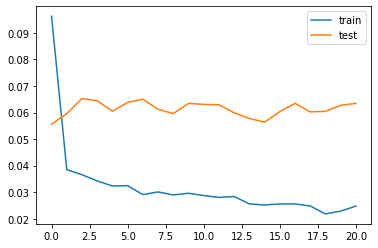

(76, 7)
(76, 7)
(76, 7)
score_train: [16.569] 14.8, 16.8, 17.0, 16.9, 17.0, 16.6, 16.8
(15, 1, 10)
score_test: [29.467] 23.5, 39.1, 46.6, 25.8, 21.5, 21.4, 15.5

RMSE test:  29.467177087841733 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.0701 - val_loss: 0.0640
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0367 - val_loss: 0.0637
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0391 - val_loss: 0.0673
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0349 - val_loss: 0.0674
Epoch 5/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0638
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0327 - val_loss: 0.0670
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0302 - val_loss: 0.0665
Epoch 8/1000
76/76 [===================

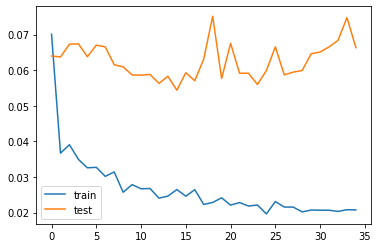

(76, 7)
(76, 7)
(76, 7)
score_train: [15.569] 14.6, 15.4, 15.5, 16.1, 16.1, 15.4, 15.8
(15, 1, 10)
score_test: [30.133] 26.3, 43.4, 46.4, 23.2, 16.7, 19.0, 21.1

RMSE test:  30.132994870859143 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.0750 - val_loss: 0.0636
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0329 - val_loss: 0.0650
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0333 - val_loss: 0.0738
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.0684
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0298 - val_loss: 0.0680
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0283 - val_loss: 0.0691
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.0631
Epoch 8/1000
76/76 [===================

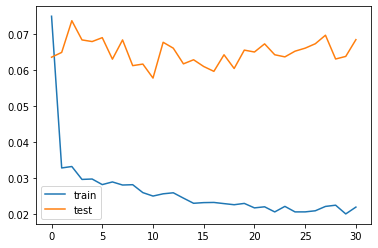

(76, 7)
(76, 7)
(76, 7)
score_train: [15.704] 14.2, 15.5, 15.4, 16.3, 16.9, 15.1, 16.3
(15, 1, 10)
score_test: [30.626] 26.1, 41.9, 46.3, 23.5, 20.3, 21.8, 23.5

RMSE test:  30.62566106236911 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0711 - val_loss: 0.0671
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0363 - val_loss: 0.0617
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0332 - val_loss: 0.0634
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0320 - val_loss: 0.0646
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0331 - val_loss: 0.0646
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0284 - val_loss: 0.0595
Epoch 7/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0284 - val_loss: 0.0609
Epoch 8/1000
76/76 [====================

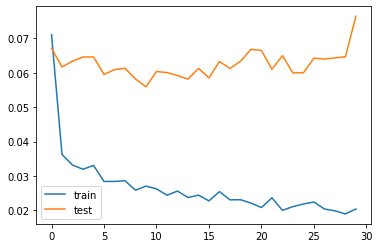

(76, 7)
(76, 7)
(76, 7)
score_train: [16.708] 14.7, 16.0, 18.5, 17.6, 17.4, 17.5, 14.9
(15, 1, 10)
score_test: [32.348] 24.2, 43.3, 52.7, 20.5, 22.1, 28.1, 19.8

RMSE test:  32.34756224235261 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.0677 - val_loss: 0.0579
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0396 - val_loss: 0.0649
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0342 - val_loss: 0.0671
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0317 - val_loss: 0.0702
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0318 - val_loss: 0.0669
Epoch 6/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0297 - val_loss: 0.0615
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.0640
Epoch 8/1000
76/76 [====================

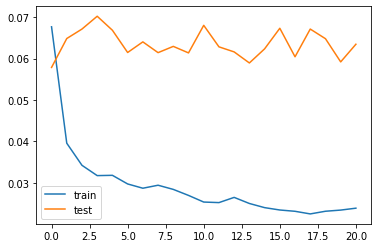

(76, 7)
(76, 7)
(76, 7)
score_train: [15.932] 14.9, 16.2, 16.1, 16.3, 16.2, 15.9, 15.7
(15, 1, 10)
score_test: [29.478] 24.0, 39.4, 45.9, 31.4, 15.7, 17.8, 17.2

RMSE test:  29.47842042993123 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.0708 - val_loss: 0.0612
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0358 - val_loss: 0.0592
Epoch 3/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0315 - val_loss: 0.0629
Epoch 4/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.0659
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0291 - val_loss: 0.0614
Epoch 6/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0646
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.0571
Epoch 8/1000
76/76 [====================

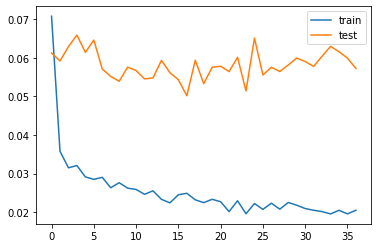

(76, 7)
(76, 7)
(76, 7)
score_train: [15.021] 13.9, 15.2, 15.2, 15.5, 15.8, 14.6, 14.8
(15, 1, 10)
score_test: [27.989] 19.4, 38.1, 45.9, 27.5, 16.3, 15.3, 17.2

RMSE test:  27.989306947042806 

7  	10    	26.9064	0       	26.9064	26.9064

Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.0700 - val_loss: 0.0733
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0371 - val_loss: 0.0676
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0311 - val_loss: 0.0661
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0344 - val_loss: 0.0624
Epoch 5/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0324 - val_loss: 0.0710
Epoch 6/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.0625
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0301 - val_loss: 0.

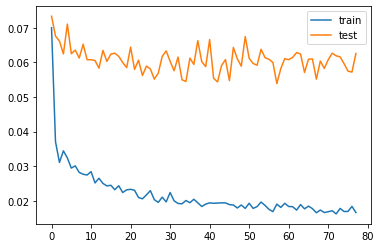

(76, 7)
(76, 7)
(76, 7)
score_train: [13.999] 13.2, 14.0, 14.7, 15.1, 14.5, 13.1, 13.2
(15, 1, 10)
score_test: [29.258] 23.8, 40.5, 46.7, 28.1, 17.3, 11.9, 19.3

RMSE test:  29.258152402011984 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0748 - val_loss: 0.0643
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0361 - val_loss: 0.0653
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0337 - val_loss: 0.0672
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.0656
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0337 - val_loss: 0.0656
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0310 - val_loss: 0.0673
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.0664
Epoch 8/1000
76/76 [===================

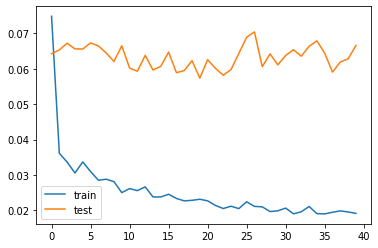

(76, 7)
(76, 7)
(76, 7)
score_train: [15.050] 13.8, 14.8, 15.5, 15.9, 16.0, 14.7, 14.6
(15, 1, 10)
score_test: [30.189] 23.4, 43.8, 45.8, 28.9, 17.5, 16.0, 20.7

RMSE test:  30.18883496494482 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.0790 - val_loss: 0.0504
Epoch 2/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0585
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0330 - val_loss: 0.0623
Epoch 4/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0333 - val_loss: 0.0626
Epoch 5/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0318 - val_loss: 0.0639
Epoch 6/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.0632
Epoch 7/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0280 - val_loss: 0.0611
Epoch 8/1000
76/76 [====================

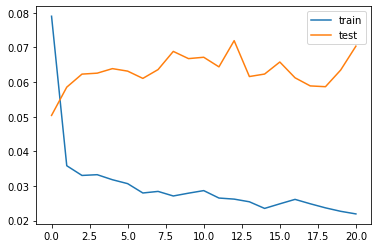

(76, 7)
(76, 7)
(76, 7)
score_train: [16.367] 14.9, 16.0, 16.3, 16.8, 16.9, 16.6, 17.0
(15, 1, 10)
score_test: [31.038] 25.7, 41.4, 49.9, 26.0, 21.6, 17.8, 20.4

RMSE test:  31.038284220387485 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 1s 8ms/step - loss: 0.0756 - val_loss: 0.0681
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0368 - val_loss: 0.0707
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0327 - val_loss: 0.0714
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0319 - val_loss: 0.0645
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.0690
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0319 - val_loss: 0.0672
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.0667
Epoch 8/1000
76/76 [===================

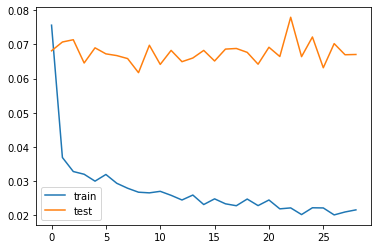

(76, 7)
(76, 7)
(76, 7)
score_train: [15.460] 14.2, 15.6, 15.3, 15.9, 16.0, 15.3, 15.9
(15, 1, 10)
score_test: [30.295] 24.8, 43.1, 47.9, 28.1, 15.3, 19.5, 15.8

RMSE test:  30.294927918221173 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0866 - val_loss: 0.0613
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0353 - val_loss: 0.0599
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0332 - val_loss: 0.0611
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0335 - val_loss: 0.0563
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0333 - val_loss: 0.0611
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 0.0587
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.0629
Epoch 8/1000
76/76 [===================

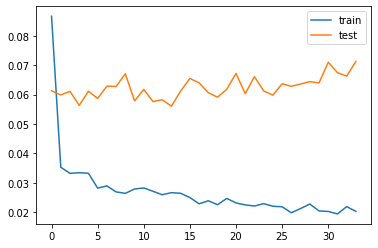

(76, 7)
(76, 7)
(76, 7)
score_train: [15.778] 15.6, 16.1, 16.3, 16.2, 16.2, 14.9, 15.1
(15, 1, 10)
score_test: [31.235] 25.1, 42.2, 51.8, 26.2, 19.5, 16.5, 20.1

RMSE test:  31.23458337541129 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.0793 - val_loss: 0.0635
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0381 - val_loss: 0.0616
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0350 - val_loss: 0.0675
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.0689
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0309 - val_loss: 0.0671
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.0687
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.0647
Epoch 8/1000
76/76 [====================

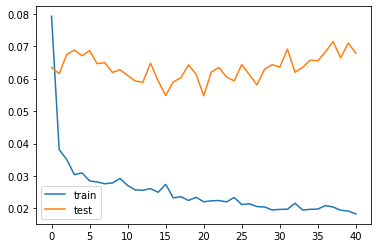

(76, 7)
(76, 7)
(76, 7)
score_train: [15.105] 14.1, 15.3, 15.0, 15.8, 15.8, 14.7, 15.0
(15, 1, 10)
score_test: [30.482] 26.6, 43.8, 45.3, 29.8, 18.4, 16.9, 17.7

RMSE test:  30.48206574626082 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0533 - val_loss: 0.0673
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0355 - val_loss: 0.0669
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0328 - val_loss: 0.0670
Epoch 4/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0300 - val_loss: 0.0625
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0310 - val_loss: 0.0675
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0315 - val_loss: 0.0677
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.0608
Epoch 8/1000
76/76 [====================

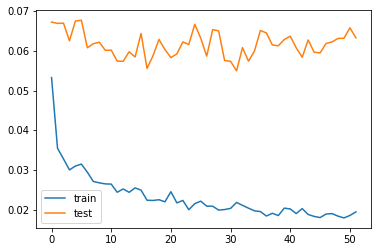

(76, 7)
(76, 7)
(76, 7)
score_train: [14.632] 14.2, 15.0, 15.2, 15.2, 15.2, 14.2, 13.4
(15, 1, 10)
score_test: [29.436] 24.9, 40.0, 46.2, 32.9, 16.6, 10.5, 15.6

RMSE test:  29.435790262596377 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0620 - val_loss: 0.0763
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0349 - val_loss: 0.0755
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0328 - val_loss: 0.0842
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0334 - val_loss: 0.0758
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0322 - val_loss: 0.0721
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.0730
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.0763
Epoch 8/1000
76/76 [===================

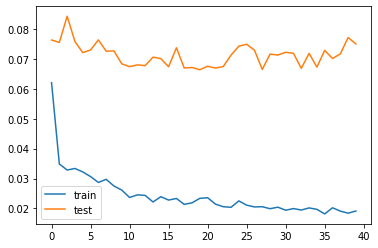

(76, 7)
(76, 7)
(76, 7)
score_train: [15.893] 13.8, 15.4, 15.8, 17.8, 17.1, 16.0, 15.1
(15, 1, 10)
score_test: [32.039] 24.0, 46.2, 48.3, 21.7, 22.7, 26.2, 21.7

RMSE test:  32.039359311176426 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0792 - val_loss: 0.0633
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0365 - val_loss: 0.0666
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0357 - val_loss: 0.0705
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0330 - val_loss: 0.0658
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0307 - val_loss: 0.0656
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0277 - val_loss: 0.0756
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0291 - val_loss: 0.0688
Epoch 8/1000
76/76 [===================

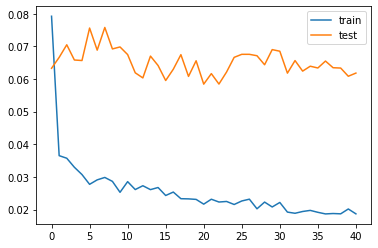

(76, 7)
(76, 7)
(76, 7)
score_train: [14.938] 14.0, 14.9, 15.7, 15.3, 15.3, 14.6, 14.6
(15, 1, 10)
score_test: [29.086] 24.0, 40.2, 45.5, 29.4, 17.0, 16.1, 15.8

RMSE test:  29.086391664113055 

8  	9     	26.9064	0       	26.9064	26.9064

Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.0788 - val_loss: 0.0677
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0359 - val_loss: 0.0645
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0346 - val_loss: 0.0697
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0318 - val_loss: 0.0687
Epoch 5/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.0635
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0311 - val_loss: 0.0629
Epoch 7/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.

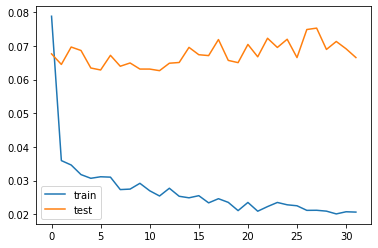

(76, 7)
(76, 7)
(76, 7)
score_train: [15.437] 14.5, 15.5, 15.5, 15.9, 16.3, 15.3, 15.1
(15, 1, 10)
score_test: [30.186] 27.0, 41.0, 46.8, 25.9, 15.2, 22.9, 18.8

RMSE test:  30.185905889310085 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.0674 - val_loss: 0.0576
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0364 - val_loss: 0.0554
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0349 - val_loss: 0.0561
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0312 - val_loss: 0.0598
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0309 - val_loss: 0.0604
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0271 - val_loss: 0.0621
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0276 - val_loss: 0.0568
Epoch 8/1000
76/76 [===================

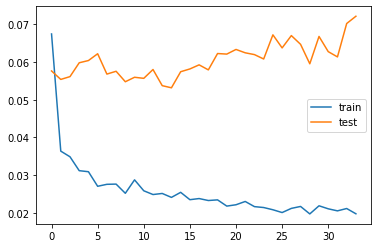

(76, 7)
(76, 7)
(76, 7)
score_train: [16.346] 15.8, 16.7, 16.8, 16.2, 17.2, 15.7, 16.0
(15, 1, 10)
score_test: [31.409] 20.1, 44.4, 47.9, 25.3, 19.2, 24.6, 25.0

RMSE test:  31.408943278589255 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0665 - val_loss: 0.0559
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0346 - val_loss: 0.0643
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0344 - val_loss: 0.0636
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0319 - val_loss: 0.0636
Epoch 5/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0300 - val_loss: 0.0649
Epoch 6/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0314 - val_loss: 0.0597
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.0627
Epoch 8/1000
76/76 [===================

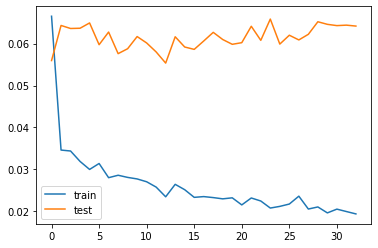

(76, 7)
(76, 7)
(76, 7)
score_train: [15.442] 14.3, 15.0, 15.7, 16.2, 16.1, 15.3, 15.3
(15, 1, 10)
score_test: [29.634] 23.0, 44.2, 44.1, 33.9, 8.0, 16.1, 16.0

RMSE test:  29.634288972026603 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.0649 - val_loss: 0.0694
Epoch 2/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0653
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0323 - val_loss: 0.0650
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0341 - val_loss: 0.0754
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.0675
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0323 - val_loss: 0.0691
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0322 - val_loss: 0.0713
Epoch 8/1000
76/76 [====================

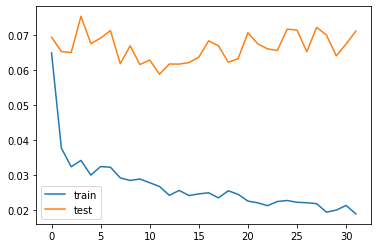

(76, 7)
(76, 7)
(76, 7)
score_train: [15.663] 15.0, 16.1, 16.0, 15.9, 15.5, 14.8, 16.4
(15, 1, 10)
score_test: [31.204] 24.2, 48.0, 46.9, 25.4, 17.7, 16.4, 22.4

RMSE test:  31.2039748933495 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.0800 - val_loss: 0.0575
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0356 - val_loss: 0.0596
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0393 - val_loss: 0.0682
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0352 - val_loss: 0.0683
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.0632
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0318 - val_loss: 0.0612
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0298 - val_loss: 0.0623
Epoch 8/1000
76/76 [=====================

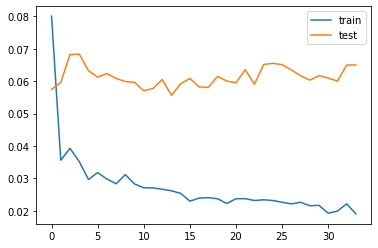

(76, 7)
(76, 7)
(76, 7)
score_train: [15.537] 14.5, 15.2, 15.5, 16.4, 16.2, 15.3, 15.5
(15, 1, 10)
score_test: [29.826] 24.9, 41.5, 47.3, 31.6, 12.7, 16.5, 14.6

RMSE test:  29.825697278910326 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0682 - val_loss: 0.0531
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0369 - val_loss: 0.0605
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0336 - val_loss: 0.0621
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0301 - val_loss: 0.0690
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.0624
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0301 - val_loss: 0.0569
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0286 - val_loss: 0.0584
Epoch 8/1000
76/76 [===================

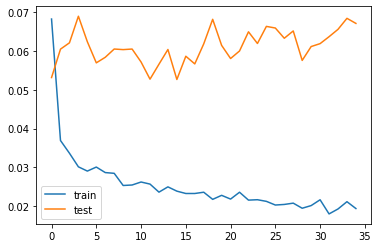

(76, 7)
(76, 7)
(76, 7)
score_train: [15.097] 14.0, 14.9, 16.1, 15.8, 15.5, 14.7, 14.7
(15, 1, 10)
score_test: [30.309] 25.7, 42.9, 48.1, 28.5, 18.7, 12.9, 17.0

RMSE test:  30.309224192166763 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0716 - val_loss: 0.0782
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0356 - val_loss: 0.0759
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0302 - val_loss: 0.0760
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0773
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0302 - val_loss: 0.0769
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0277 - val_loss: 0.0745
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0301 - val_loss: 0.0712
Epoch 8/1000
76/76 [===================

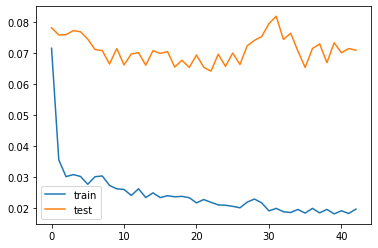

(76, 7)
(76, 7)
(76, 7)
score_train: [14.788] 14.4, 14.9, 15.0, 15.2, 15.6, 14.1, 14.1
(15, 1, 10)
score_test: [31.174] 28.0, 44.2, 48.9, 29.1, 13.4, 18.0, 18.1

RMSE test:  31.173868523883193 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0597 - val_loss: 0.0643
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0360 - val_loss: 0.0643
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0355 - val_loss: 0.0666
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0325 - val_loss: 0.0671
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0300 - val_loss: 0.0618
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0303 - val_loss: 0.0700
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0298 - val_loss: 0.0719
Epoch 8/1000
76/76 [===================

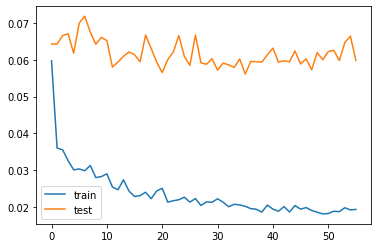

(76, 7)
(76, 7)
(76, 7)
score_train: [14.636] 13.4, 14.6, 15.3, 15.1, 15.5, 14.5, 14.0
(15, 1, 10)
score_test: [28.614] 24.9, 39.5, 42.5, 30.4, 13.1, 17.7, 18.4

RMSE test:  28.613906669169605 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0704 - val_loss: 0.0776
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0346 - val_loss: 0.0716
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0332 - val_loss: 0.0731
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0334 - val_loss: 0.0749
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.0739
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0316 - val_loss: 0.0685
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.0735
Epoch 8/1000
76/76 [===================

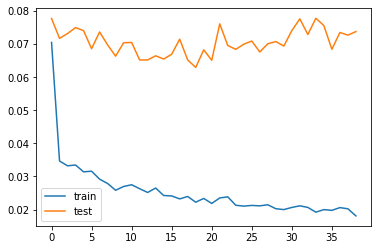

(76, 7)
(76, 7)
(76, 7)
score_train: [15.511] 14.2, 16.7, 15.5, 16.0, 15.9, 15.2, 15.0
(15, 1, 10)
score_test: [31.755] 25.3, 46.8, 48.1, 24.6, 17.4, 20.1, 24.5

RMSE test:  31.754859894074222 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0595 - val_loss: 0.0670
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0351 - val_loss: 0.0622
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0349 - val_loss: 0.0665
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0331 - val_loss: 0.0656
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.0691
Epoch 6/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0293 - val_loss: 0.0697
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0301 - val_loss: 0.0719
Epoch 8/1000
76/76 [===================

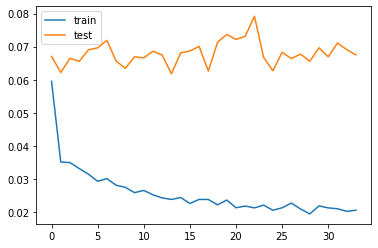

(76, 7)
(76, 7)
(76, 7)
score_train: [15.114] 14.1, 14.9, 15.2, 15.6, 15.9, 15.3, 14.8
(15, 1, 10)
score_test: [30.400] 29.0, 41.0, 46.7, 29.3, 17.2, 14.1, 20.4

RMSE test:  30.399938703050395 

9  	10    	26.9064	0       	26.9064	26.9064

Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.0729 - val_loss: 0.0631
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0373 - val_loss: 0.0652
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.0640
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0327 - val_loss: 0.0699
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0303 - val_loss: 0.0634
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0289 - val_loss: 0.0701
Epoch 7/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.

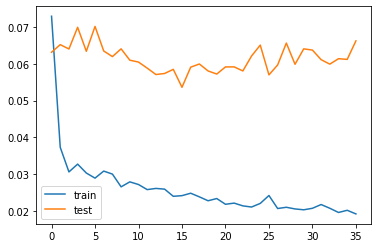

(76, 7)
(76, 7)
(76, 7)
score_train: [15.418] 14.0, 15.5, 16.3, 16.2, 15.8, 15.5, 14.4
(15, 1, 10)
score_test: [30.108] 24.4, 40.7, 48.9, 23.8, 14.8, 21.2, 21.7

RMSE test:  30.10821468658799 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 1s 9ms/step - loss: 0.0805 - val_loss: 0.0662
Epoch 2/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0384 - val_loss: 0.0824
Epoch 3/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0697
Epoch 4/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0728
Epoch 5/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0318 - val_loss: 0.0672
Epoch 6/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0289 - val_loss: 0.0680
Epoch 7/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0315 - val_loss: 0.0716
Epoch 8/1000
76/76 [====================

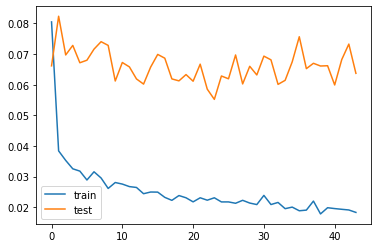

(76, 7)
(76, 7)
(76, 7)
score_train: [14.960] 13.7, 15.4, 15.6, 15.3, 15.7, 14.5, 14.5
(15, 1, 10)
score_test: [29.532] 23.3, 38.1, 48.0, 31.4, 16.4, 13.7, 19.1

RMSE test:  29.531819773772796 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0798 - val_loss: 0.0555
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0348 - val_loss: 0.0583
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0344 - val_loss: 0.0632
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0332 - val_loss: 0.0718
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0310 - val_loss: 0.0653
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0303 - val_loss: 0.0650
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.0720
Epoch 8/1000
76/76 [===================

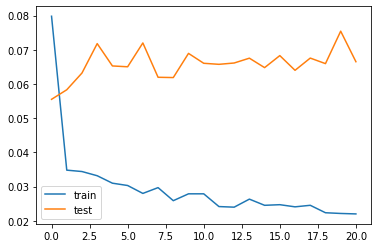

(76, 7)
(76, 7)
(76, 7)
score_train: [15.910] 14.7, 15.8, 16.2, 16.3, 16.6, 16.1, 15.6
(15, 1, 10)
score_test: [30.178] 30.4, 38.5, 46.9, 28.0, 15.9, 20.8, 17.3

RMSE test:  30.178485352553942 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.0550 - val_loss: 0.0737
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0345 - val_loss: 0.0682
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0340 - val_loss: 0.0662
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0336 - val_loss: 0.0721
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0289 - val_loss: 0.0712
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.0657
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.0605
Epoch 8/1000
76/76 [===================

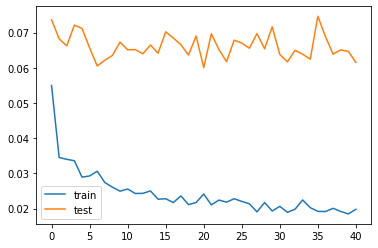

(76, 7)
(76, 7)
(76, 7)
score_train: [15.913] 14.4, 15.0, 15.8, 16.5, 16.8, 16.5, 16.2
(15, 1, 10)
score_test: [29.022] 26.5, 39.6, 42.4, 34.9, 11.9, 12.9, 17.2

RMSE test:  29.02153916949464 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.1004 - val_loss: 0.0535
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0370 - val_loss: 0.0567
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0338 - val_loss: 0.0600
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0305 - val_loss: 0.0625
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0307 - val_loss: 0.0668
Epoch 6/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.0597
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0305 - val_loss: 0.0667
Epoch 8/1000
76/76 [====================

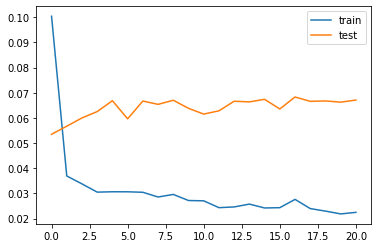

(76, 7)
(76, 7)
(76, 7)
score_train: [16.072] 15.1, 15.6, 16.1, 16.3, 16.8, 16.2, 16.4
(15, 1, 10)
score_test: [30.311] 28.1, 38.7, 48.7, 29.7, 19.3, 13.0, 18.6

RMSE test:  30.310968888668633 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0778 - val_loss: 0.0650
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0353 - val_loss: 0.0679
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0344 - val_loss: 0.0685
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0333 - val_loss: 0.0664
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0286 - val_loss: 0.0678
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.0669
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0279 - val_loss: 0.0671
Epoch 8/1000
76/76 [===================

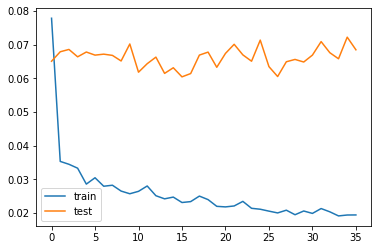

(76, 7)
(76, 7)
(76, 7)
score_train: [15.803] 14.1, 14.9, 16.1, 16.6, 17.3, 16.1, 15.3
(15, 1, 10)
score_test: [30.609] 23.6, 39.9, 49.3, 23.5, 19.8, 22.5, 22.9

RMSE test:  30.608987802381765 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0661 - val_loss: 0.0647
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0333 - val_loss: 0.0701
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0321 - val_loss: 0.0697
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0337 - val_loss: 0.0736
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0311 - val_loss: 0.0652
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.0652
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0273 - val_loss: 0.0645
Epoch 8/1000
76/76 [===================

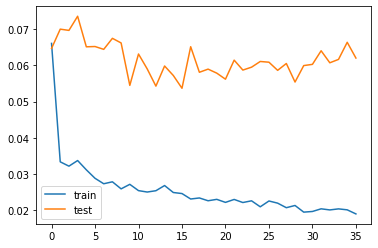

(76, 7)
(76, 7)
(76, 7)
score_train: [14.998] 14.2, 15.3, 15.5, 15.5, 15.4, 14.6, 14.5
(15, 1, 10)
score_test: [29.146] 25.7, 35.4, 46.0, 32.1, 20.3, 14.2, 16.5

RMSE test:  29.145952852447174 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.0825 - val_loss: 0.0669
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0347 - val_loss: 0.0708
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0345 - val_loss: 0.0703
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0313 - val_loss: 0.0682
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.0733
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.0672
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.0702
Epoch 8/1000
76/76 [===================

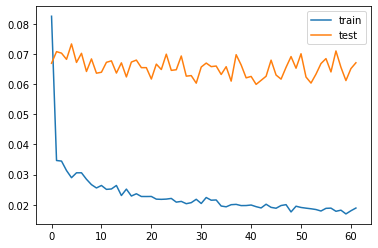

(76, 7)
(76, 7)
(76, 7)
score_train: [14.408] 13.4, 14.6, 15.2, 15.1, 15.0, 13.7, 13.7
(15, 1, 10)
score_test: [30.306] 23.5, 46.2, 46.3, 30.7, 18.4, 9.5, 15.1

RMSE test:  30.306005984885765 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  2
(76, 1, 10)
Epoch 1/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0595 - val_loss: 0.0595
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0324 - val_loss: 0.0586
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0322 - val_loss: 0.0586
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0300 - val_loss: 0.0601
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.0677
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.0603
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0269 - val_loss: 0.0602
Epoch 8/1000
76/76 [====================

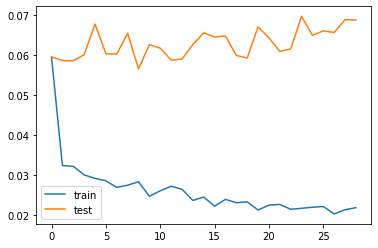

(76, 7)
(76, 7)
(76, 7)
score_train: [16.039] 14.2, 15.7, 15.8, 16.7, 16.4, 16.3, 17.0
(15, 1, 10)
score_test: [30.680] 22.9, 43.3, 47.0, 23.1, 18.5, 22.8, 24.4

RMSE test:  30.68040872236005 

10 	9     	26.9064	0       	26.9064	26.9064


In [76]:
population_size = 10
num_generations = 10
# 8 bits for ltsm1 , 8 for lstm 2 , 6 for sequence length , 21 for features selections
# 8 bits for cnn1 ,8 bits for cnn2 , 8 bits for lstm 2 ,8 bits for lstm 2 , 6 bits for sequence length , 21 for features selections
gene_length =14 #58

# As we are trying to minimize the RMSE score, that's why using -1.0. 
# In case, when you want to maximize accuracy for instance, use 1.0
creator.create('FitnessMax', base.Fitness, weights = (-1.0,))
creator.create('Individual', list , fitness = creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.9)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, n = gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.7)
toolbox.register('select', tools.selRoulette)
toolbox.register('evaluate', train_evaluate)
population = toolbox.population(n = population_size)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
#param cxpb: The probability of mating two individuals.
#param mutpb: The probability of mutating an individual.
population , logbook  = algorithms.eaSimple(population, toolbox,halloffame=hof, cxpb = 0.7, mutpb = 0.6,stats=stats, ngen = num_generations, verbose = True)

In [77]:
print('Best score :', best_score)

Best score : 26.90640105187532


In [78]:
model=model_name
model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_26 (Conv1D)           (None, 1, 127)            2667      
_________________________________________________________________
flatten_26 (Flatten)         (None, 127)               0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 127)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 7)                 896       
Total params: 3,563
Trainable params: 3,563
Non-trainable params: 0
_________________________________________________________________


In [79]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# make a prediction
yhat = model.predict(X_test[[0,7,14]])
yhat.shape 

(3, 7)

In [80]:
yhat = yhat.reshape(-1, yhat.shape[-1])

In [81]:
#yhat

In [82]:
# invert scaling for forecast
y_test_pred = scaler2.inverse_transform(yhat)
#print(inv_yhat)
# invert scaling for actual
Y_test_true =Y_test[[0,7,14]]
Y_test_true = Y_test_true.reshape(-1, Y_test_true.shape[-1])
y_test_true= scaler2.inverse_transform(Y_test_true)
#print(inv_y)

In [83]:
days

DatetimeIndex(['2020-05-25', '2020-05-26', '2020-05-27', '2020-05-28',
               '2020-05-29', '2020-05-30', '2020-05-31', '2020-06-01',
               '2020-06-02', '2020-06-03', '2020-06-04', '2020-06-05',
               '2020-06-06', '2020-06-07', '2020-06-08', '2020-06-09',
               '2020-06-10', '2020-06-11', '2020-06-12', '2020-06-13',
               '2020-06-14'],
              dtype='datetime64[ns]', name='timestamp', freq=None)

In [84]:
test_res=pd.DataFrame()
test_res['Prediction']=y_test_pred.flatten()[0:21]
test_res['real']=y_test_true.flatten()[0:21]
test_res.set_index(days,inplace=True)

In [85]:
test_res

,Prediction,real
timestamp,,
2020-05-25,47.149910,27.0
2020-05-26,45.040863,99.0
2020-05-27,47.122761,45.0
2020-05-28,43.630089,24.0
2020-05-29,60.413139,42.0
2020-05-30,51.873840,71.0
2020-05-31,54.759457,66.0
2020-06-01,53.940075,27.0
2020-06-02,61.871399,26.0


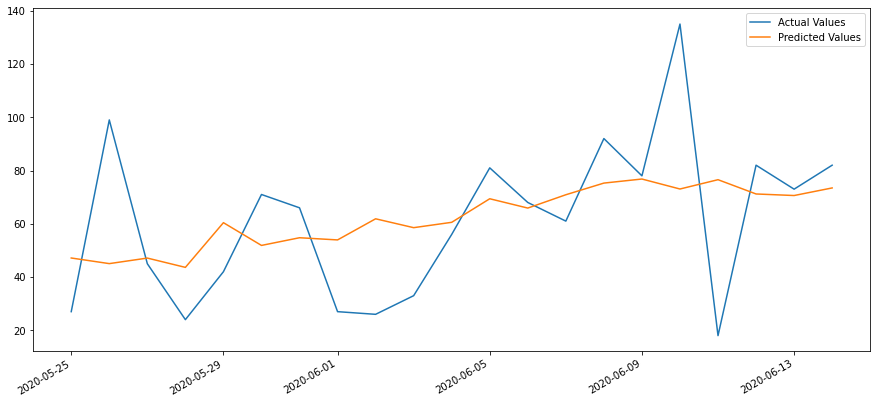

In [86]:

import pandas as pd
import numpy as np; np.random.seed(1)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,7))
plt.plot(test_res.index, test_res['real'],  label='Actual Values')
plt.plot(test_res.index, test_res['Prediction'], label='Predicted Values')
# If you don't like the break in the graph, change 90 to 89 in the above line
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()




In [87]:
import numpy as np 
from sklearn import metrics
print('Test Metrics')
print('MSE:', round(metrics.mean_squared_error(test_res['real'], test_res['Prediction']), 2))
print('RMSE:',round( np.sqrt(metrics.mean_squared_error(test_res['real'], test_res['Prediction'])), 2))
print('MAE:', round(metrics.mean_absolute_error(test_res['real'], test_res['Prediction']), 2))
print('R Squared:', round( metrics.r2_score(test_res['real'], test_res['Prediction']), 2))
print('Max Error:',round(  metrics.max_error(test_res['real'], test_res['Prediction']), 2))


Test Metrics
MSE: 723.95
RMSE: 26.91
MAE: 20.06
R Squared: 0.15
Max Error: 61.94


In [88]:
# make a prediction
y_train_pred = model.predict(X_train)
y_train_pred .shape

(76, 7)

In [89]:
y_train_pred = y_train_pred.reshape(y_train_pred.shape[0], y_train_pred.shape[1])
y_train_pred.shape

(76, 7)

In [90]:

# invert scaling for forecast

y_train_pred = scaler2.inverse_transform(y_train_pred)
Y_train_true = Y_train.reshape((len(Y_train), n_out))

y_train_real = scaler2.inverse_transform(Y_train_true )

In [91]:

# Flatten for final errors
Y_train_pred_bis = y_train_pred.flatten()
Y_train_real_bis = y_train_real.flatten()

In [92]:
y_train_pred[0]

array([23.575283, 24.025833, 24.145641, 24.299006, 23.822765, 25.711061,
       27.563423], dtype=float32)

In [93]:
#For plot 
#filter_indices = [0,6,13,20,27,34,41,48,55,62,69,76,83,90,97,104]
filter_indices = [0,6,13,20,27,34,41,48,55,62,69]
y_train_pred = y_train_pred [filter_indices ]

In [94]:
# Part of train dataset
y_train_real= y_train_real[filter_indices]
Y_train_pred = y_train_pred.flatten()
Y_train_real = y_train_real.flatten()

In [95]:
mask = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))
date_train = df.loc[mask].date.sort_index(axis = 0) 
X_train.shape

(76, 1, 10)

In [96]:
date_train.head(7)

22928   2020-03-02
22929   2020-03-03
22930   2020-03-04
22931   2020-03-05
22932   2020-03-06
22933   2020-03-07
22934   2020-03-08
Name: date, dtype: datetime64[ns]

In [97]:
taille_x = date_train.shape[0] - nb_seq
taille_x 

82

In [98]:
date_train = date_train.values.flatten()

In [99]:
prediction_train = pd.DataFrame(columns=['date_to_prediction','true_value','predict'])

In [100]:
Y_train_pred.shape

(77,)

In [101]:
Y_train_real.shape

(77,)

In [102]:
date_train.shape

(84,)

In [103]:
date_train[nb_seq:].shape

(82,)

In [104]:
suite_size = Y_train_real.shape[0]- date_train[nb_seq:].shape[0]
suite_size 

-5

In [105]:
Y_train_real[:-suite_size].shape

(5,)

In [106]:
date_train[nb_seq:].shape

(82,)

In [107]:
Y_train_pred[:-suite_size].shape

(5,)

In [108]:
Y_train_real[:-suite_size].shape

(5,)

In [109]:
date_trainX = date_train[nb_seq:]

In [110]:
date_trainX[0:Y_train_pred.shape[0]].shape

(77,)

In [111]:
prediction_train['date_to_prediction'] = date_trainX[0:Y_train_pred.shape[0]]
prediction_train['predict'] = Y_train_pred
prediction_train['true_value'] = Y_train_real


In [112]:
prediction_train['date_to_prediction'] = pd.to_datetime(prediction_train['date_to_prediction'], infer_datetime_format=True)

In [113]:
prediction_train.set_index('date_to_prediction',inplace=True)

In [114]:
prediction_train.head(20)

,true_value,predict
date_to_prediction,,
2020-03-04,20.914591,23.575283
2020-03-05,20.914591,24.025833
2020-03-06,18.416370,24.145641
2020-03-07,20.914591,24.299006
2020-03-08,20.914591,23.822765
2020-03-09,20.914591,25.711061
2020-03-10,20.914591,27.563423
2020-03-11,20.914591,22.872997
2020-03-12,20.914591,24.480694


In [115]:
prediction_train.tail(10)

,true_value,predict
date_to_prediction,,
2020-05-10,85.868317,83.051918
2020-05-11,100.857651,80.638618
2020-05-12,81.704620,82.208931
2020-05-13,108.768677,88.835205
2020-05-14,75.042702,88.170448
2020-05-15,57.138786,81.015984
2020-05-16,57.555161,80.489349
2020-05-17,36.736652,77.433083
2020-05-18,55.056934,71.193840


"\nfig, ax = plt.subplots(figsize=(15,7))\nplt.plot(test_res.index, test_res['real'],  label='Actual Values')\nplt.plot(test_res.index, test_res['Prediction'], label='Predicted Values')\n# If you don't like the break in the graph, change 90 to 89 in the above line\nplt.gcf().autofmt_xdate()\nplt.legend()\nplt.show()\n"

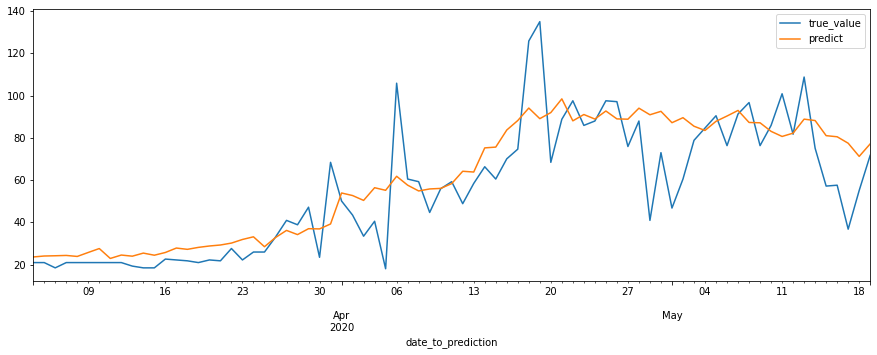

In [116]:
# Prédiction du train vs la réalité 
prediction_train.plot(figsize=(15,5))
'''
fig, ax = plt.subplots(figsize=(15,7))
plt.plot(test_res.index, test_res['real'],  label='Actual Values')
plt.plot(test_res.index, test_res['Prediction'], label='Predicted Values')
# If you don't like the break in the graph, change 90 to 89 in the above line
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()
'''

In [117]:
print('Trains Metrics')
loss = tf.keras.losses.mean_squared_error(Y_train_real_bis, Y_train_pred_bis )
print('MSE',"{:.2f}".format(loss))
rmse = tf.sqrt(tf.losses.mean_squared_error(Y_train_real_bis, Y_train_pred_bis ))
print('RMSE',"{:.2f}".format(rmse))
loss2 = tf.keras.losses.MAE(Y_train_real_bis, Y_train_pred_bis )
print('MAE',"{:.2f}".format(loss2))
r2 =r2_score(Y_train_real_bis, Y_train_pred_bis )
print('R2',"{:.2f}".format(r2))
maxerror=max_error(Y_train_real_bis, Y_train_pred_bis )
print('maxError',"{:.2f}".format(maxerror))

Trains Metrics
MSE 267.23
RMSE 16.35
MAE 11.74
R2 0.68
maxError 52.46
